In [20]:
# Steepest descent and Newton line-search methods applied to LJ7 cluster in 3D 
import numpy as np
import matplotlib.pyplot as plt
from LJhelpers import *

In [21]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [22]:
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for backtracking line search
c = 0.1;
rho = 0.9;


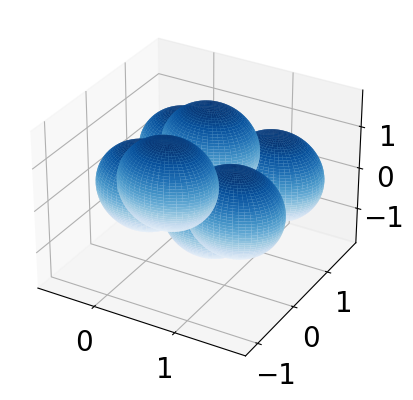

LJpot =  -15.921231995884773


In [23]:
model = 2
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x),0.5*rstar)
print("LJpot = ",LJpot(x))
#print(LJhess(x))

In [66]:
# start minimization
# choose algorithm
# direction = 0: steepest descent
# direction = 1: Newton
# direction = 2: BFGS

def LineSearch(x,p):
    # normalize the search direction if its length greater than 1
    norm_p = np.linalg.norm(p)
    if( norm_p > 1):
        p = p/norm_p
    # do backtracking line search along the direction p
    a = 1 # initial step length
    f_temp = LJpot(x + a*p)
    cpg = c*np.dot(p,g)
#     print("cpg = ",cpg,"f = ",f,"f_temp = ",f_temp)
    while( f_temp > f + a*cpg ): # check Wolfe's condition 1
        a = a*rho
        if( a < 1e-14 ):
#             print("line search failed\n");
            iter = iter_max-1
            break
        f_temp = LJpot(x + a*p)        
#         print("f_temp = ",f_temp)
    return a

def Minimization(x,model,direction,randtrial=0,BFGSreset=5):
    
    n = np.size(x, axis = 0)
    f = LJpot(x)
    g = LJgrad(x)
    norm_g = np.linalg.norm(g)
    print("Initially, f = ",f,", ||grad f|| = ",norm_g)

    fvals = np.zeros(iter_max)
    fvals[0] = f
    ngvals = np.zeros(iter_max)
    ngvals[0] = norm_g
    
    iter = 1
    
    # first iteration of BFGS
    if direction == 2:
        H = np.eye(n)
        p = -g
        a = LineSearch(x,p)
#         print('a',a)
        x_old = x
        x = x + a*p
        f = LJpot(x)
        g_old = g
        g = LJgrad(x)
        norm_g = np.linalg.norm(g)
        fvals[iter] = f
        ngvals[iter] = norm_g
        iter = iter + 1

    while (norm_g > tol and iter < iter_max): 
        #choose search direction
        if( direction == 0): # steepest descent
            p = -g
            dir = "SD"
        elif( direction == 1): # Newton
            H = LJhess(x)
            p = np.linalg.solve(H,-g) 
            # if( np.dot(g,p) < 0 ): # descent direction
                # dir = "Newton"            
    #         print(np.linalg.eigvals(H))
            spd = np.all(np.linalg.eigvals(H) > 0)
            if( spd ): # H is SPD, use Newton's direction
                p = np.linalg.solve(H,-g) 
                dir = "Newton"
            else: # use the steepest descent direction
                p = -g
                dir = "SD";
        elif(direction == 2): # BFGS
            dir = "BFGS"
            if iter%BFGSreset == 0:
                H = np.eye(n)
                p = -g
            else:
                s = (x - x_old).reshape(-1,1)
                y = (g - g_old).reshape(-1,1)
                aux1 = (H@s@s.T@H)/(s.T@H@s)
                aux2 = (y@y.T)/(y.T@s)
                H = H - aux1 + aux2
                p = np.linalg.solve(H,-g)
        else:
            print("direction is out of range")
            break
        a = LineSearch(x,p)
#         print('a',a)
        x_old = x
        x = x + a*p
        f = LJpot(x)
        g_old = g
        g = LJgrad(x)
        norm_g = np.linalg.norm(g)
    #     print("iter ",iter,": dir = ",dir,", f = ",f,", ||grad f|| = ",norm_g,", step length = ",a)
#         print(f"iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}")
        if( iter%100 == 0 ):
            # restore all coordinates
            xyz = LJvector2array(x)
#             drawconf(xyz,0.5*rstar)
        fvals[iter] = f
        ngvals[iter] = norm_g
        iter = iter + 1
    print(f"Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}")

    # visualize the final configuration and plot graphs
#     xyz = LJvector2array(x)    
#     drawconf(xyz,0.5*rstar)

    # plot title
    title_info = "model = {}, direction = {}".format(model,direction)
    if model == 0:
        title_info = title_info + ", trial = {}".format(randtrial)
    if direction == 2:
        title_info = title_info + ", BFGSreset = {}".format(BFGSreset) 

    # plot function values
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(np.arange(iter),fvals[0:iter],linewidth = 2)
    plt.xlabel("Iteration #")
    plt.ylabel("Function values")
    plt.title("Function values for "+title_info)
    plt.savefig("Function values for "+title_info)
    plt.show()

    # plot norm of gradient
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(8,8))
    plt.plot(np.arange(iter),ngvals[0:iter],linewidth = 2)
    plt.xlabel("Iteration #")
    plt.ylabel("||grad f||")
    plt.yscale("log")
    plt.title("Gradient norm for "+title_info)
    plt.savefig("Gradient norm for "+title_info)
    plt.show()

    # plot eigenvalues of Hessian
#     plt.rcParams.update({'font.size': 20})
#     H = LJhess(x)
#     evals = np.sort(np.linalg.eigvals(H))
#     plt.figure(figsize=(8,8))
#     plt.scatter(np.arange(np.size(x)),evals,s = 20)
#     plt.xlabel("index")
#     plt.ylabel("Eigenvalues of the Hessian")
#     if( evals[0] > 0 ):
#         plt.yscale("log")
#     plt.show()

Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: f = -11.5176628722, ||grad f|| = 1.646863e+01


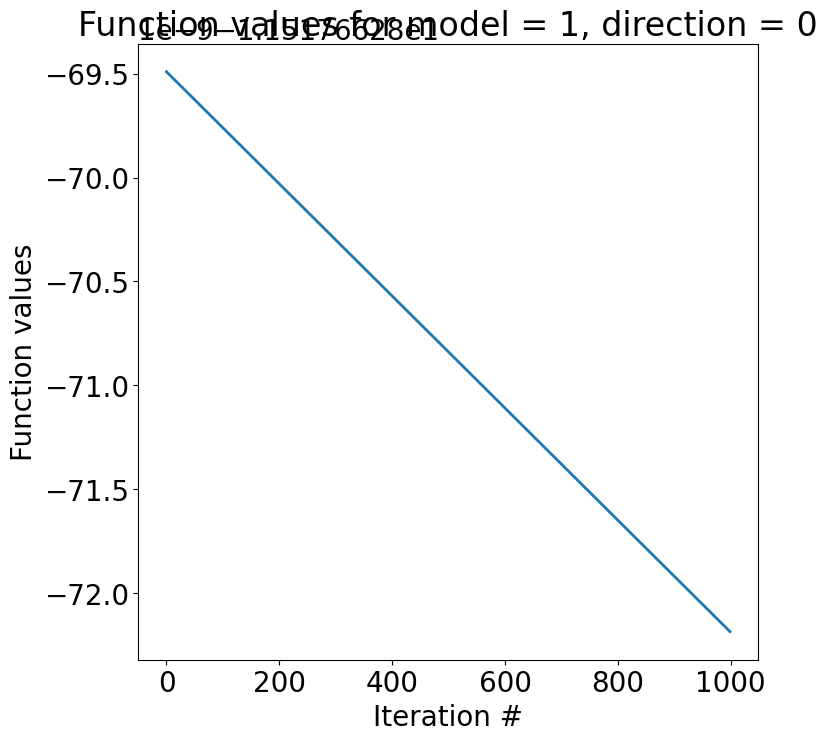

Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: f = -11.5176628722, ||grad f|| = 1.646863e+01


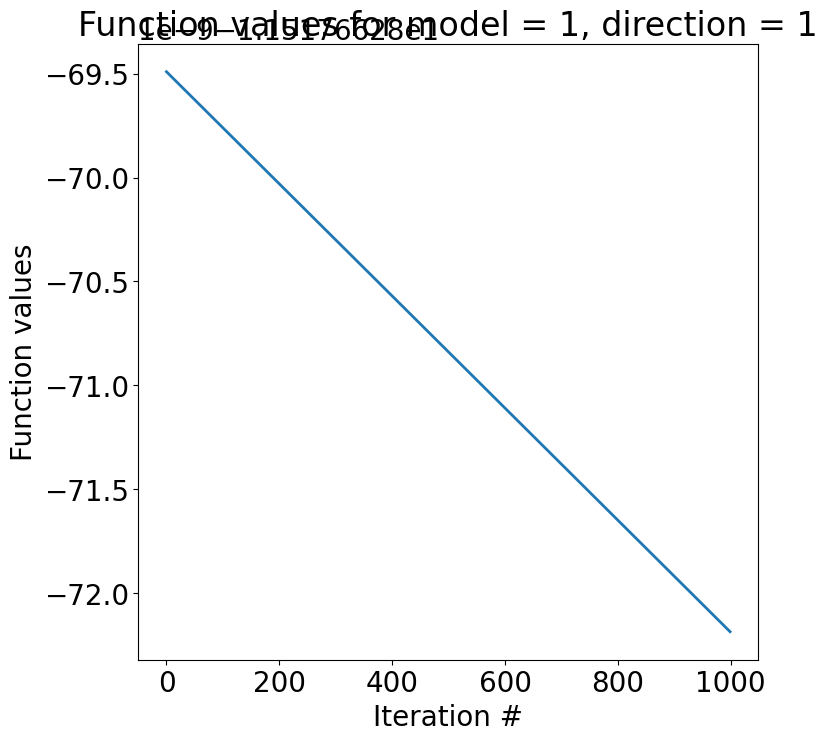

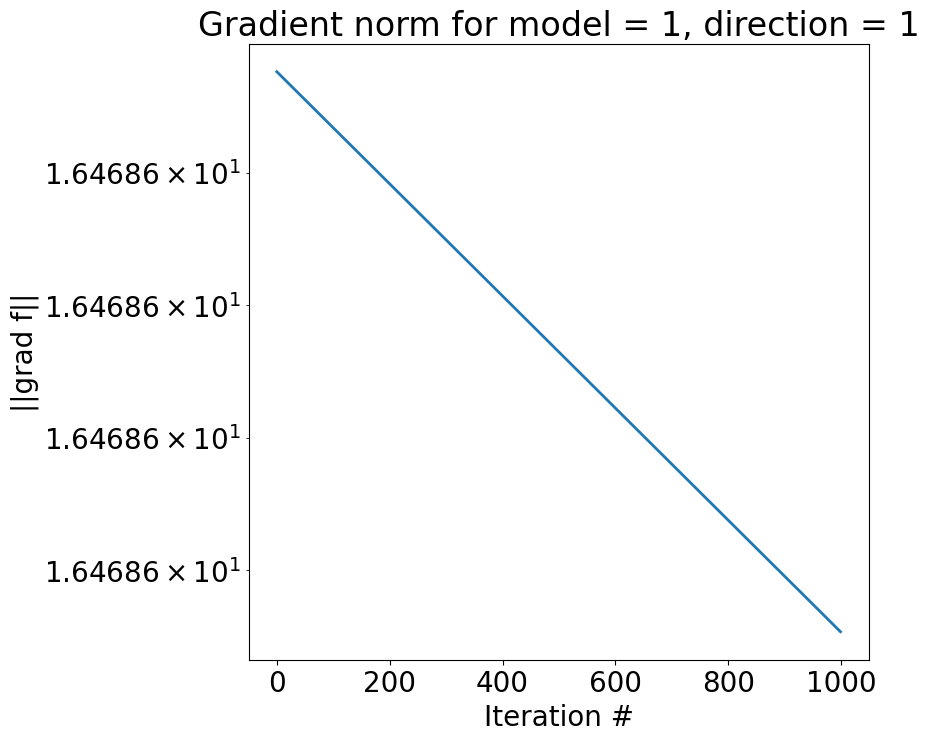

Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: f = -11.5176628805, ||grad f|| = 1.646863e+01


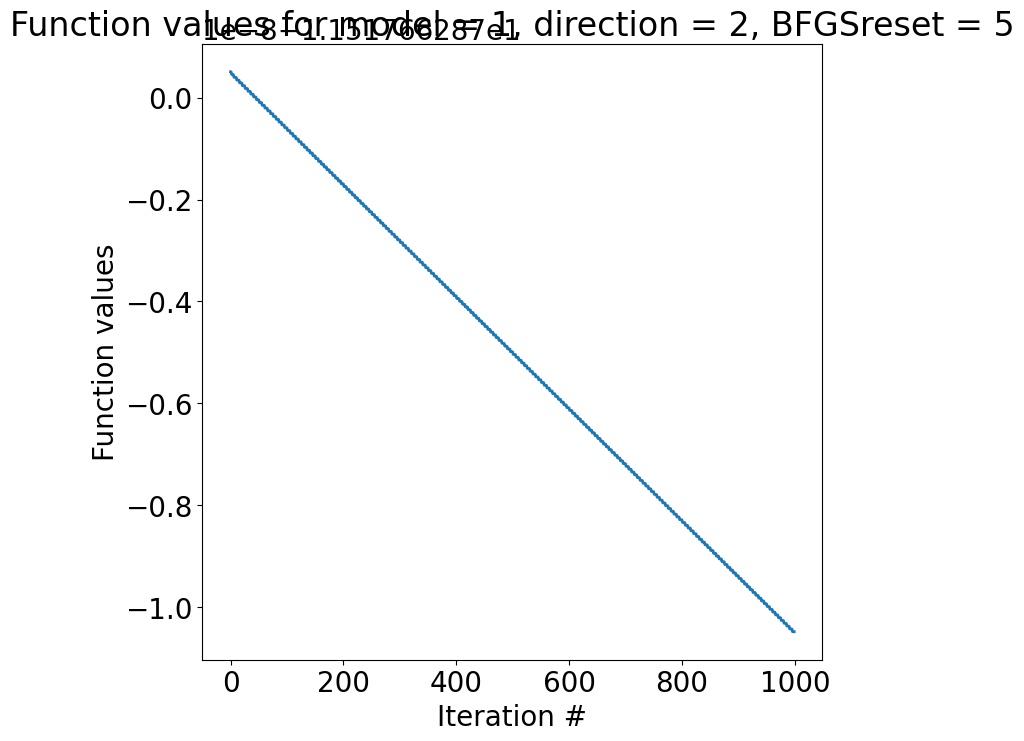

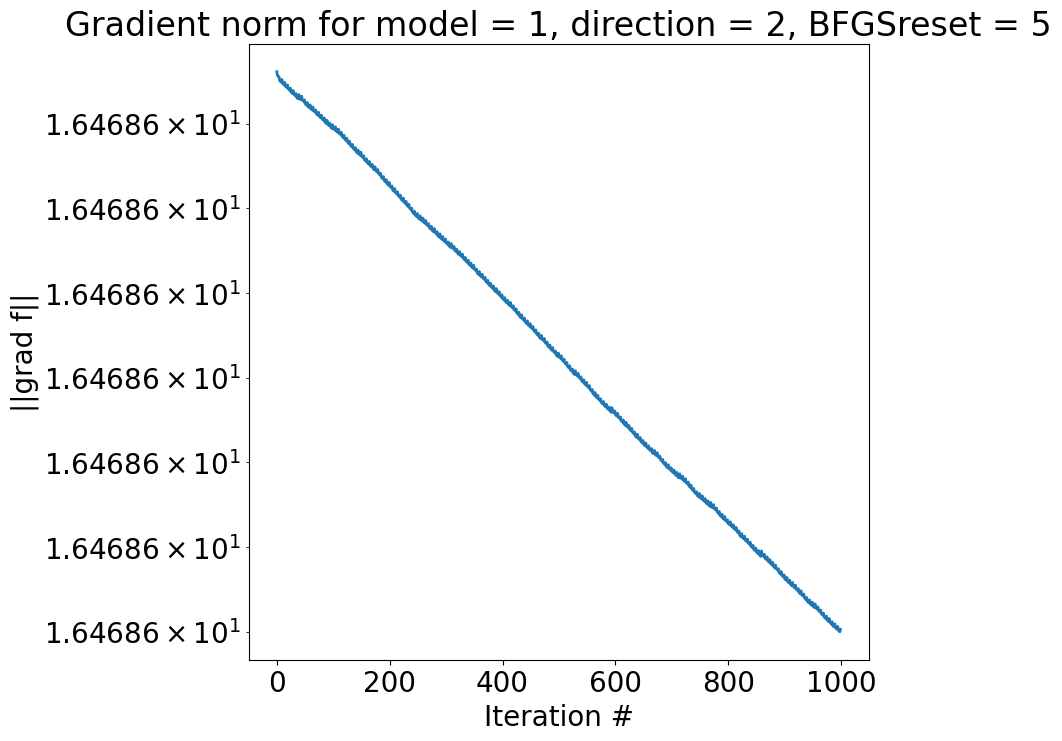

Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Result: f = -11.5176630033, ||grad f|| = 1.646863e+01


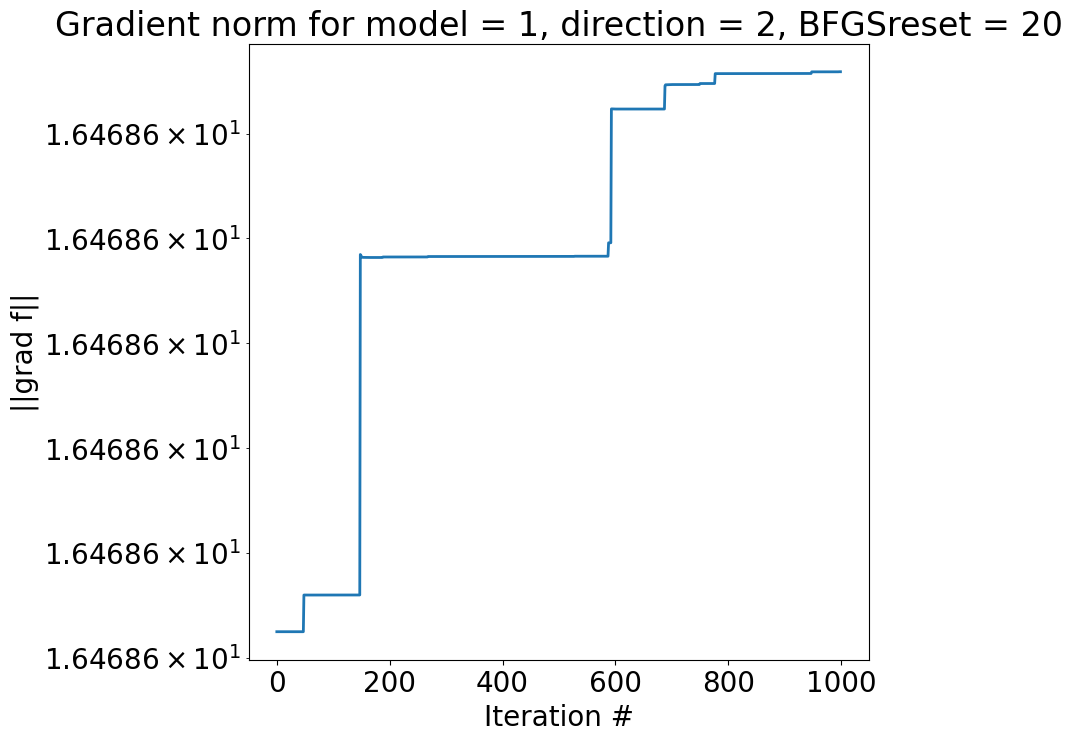

Initially, f =  -15.921231995884773 , ||grad f|| =  2.1196800775302758
Result: f = -0.0570276156, ||grad f|| = 1.057128e-01


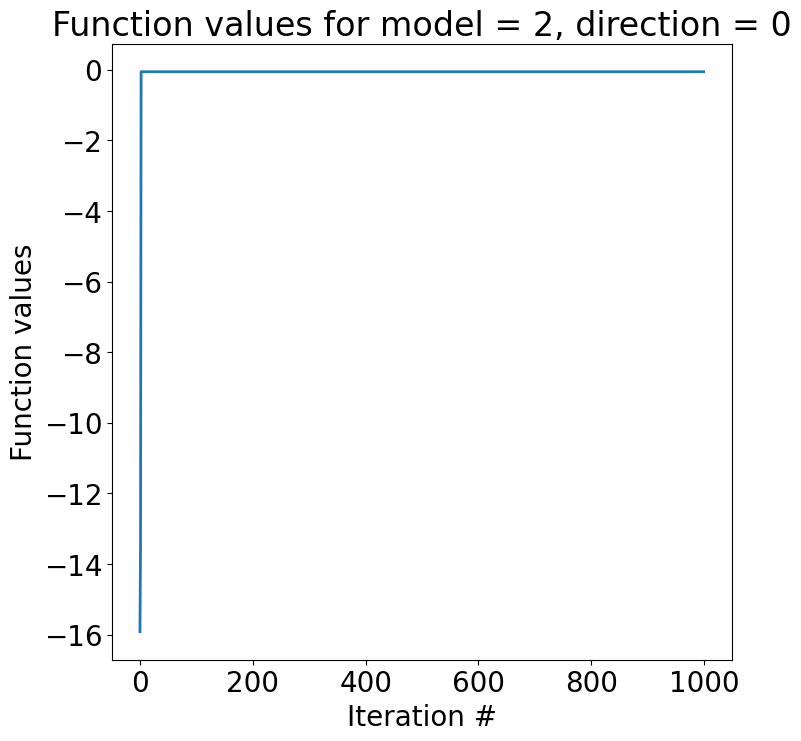

Initially, f =  -15.921231995884773 , ||grad f|| =  2.1196800775302758
Result: f = -15.9350430605, ||grad f|| = 2.792914e-14


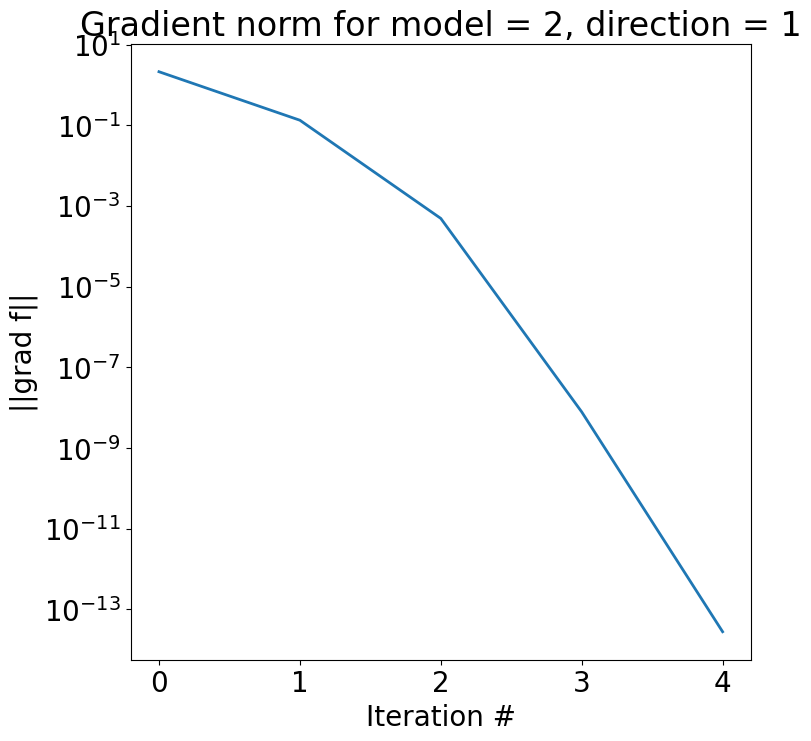

Initially, f =  -15.921231995884773 , ||grad f|| =  2.1196800775302758
Result: f = -0.0570276156, ||grad f|| = 1.057128e-01


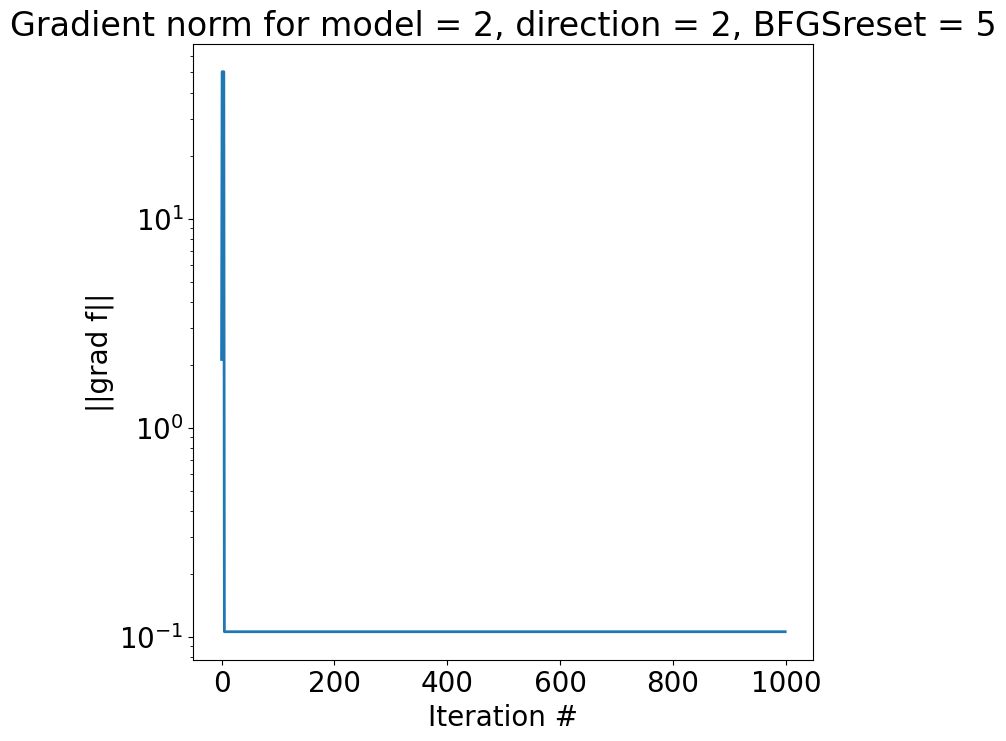

Initially, f =  -15.921231995884773 , ||grad f|| =  2.1196800775302758
Result: f = -0.0570276156, ||grad f|| = 1.057128e-01


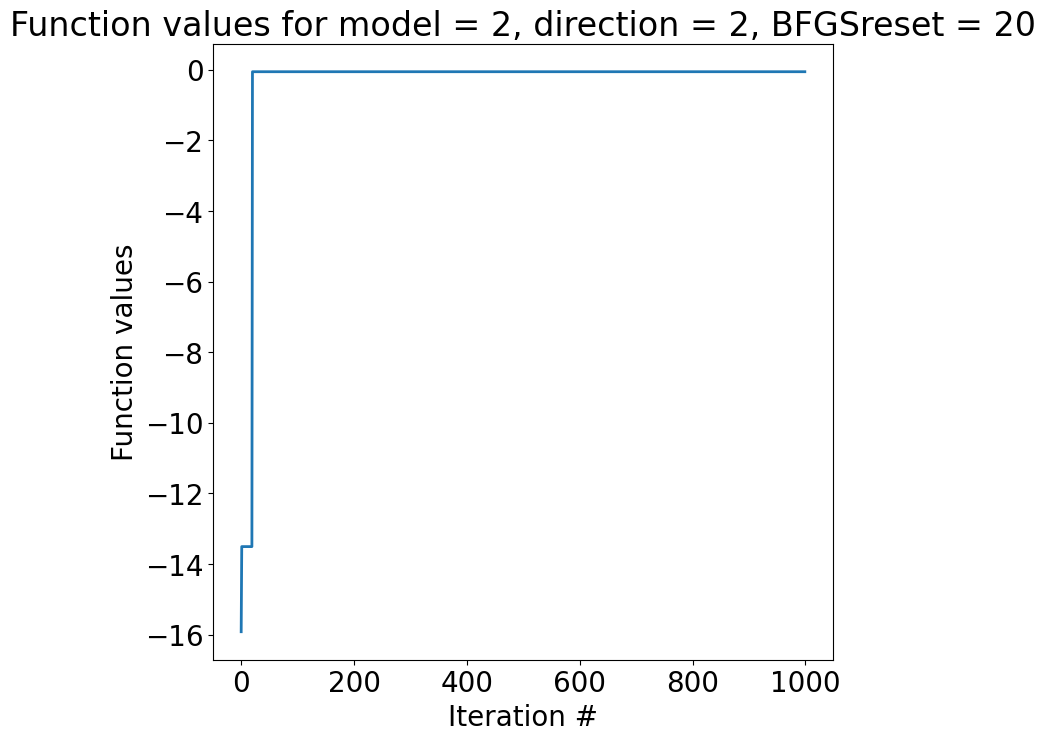

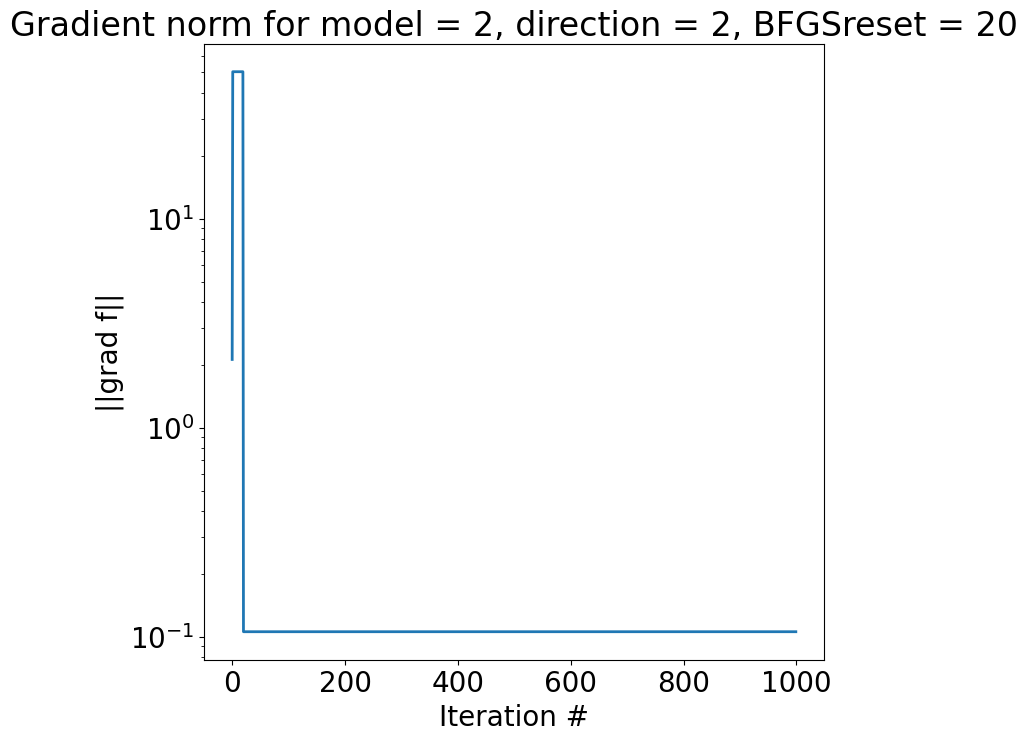

Initially, f =  -15.581469160072078 , ||grad f|| =  1.4608366392938223
Result: f = -15.5814691601, ||grad f|| = 1.460837e+00


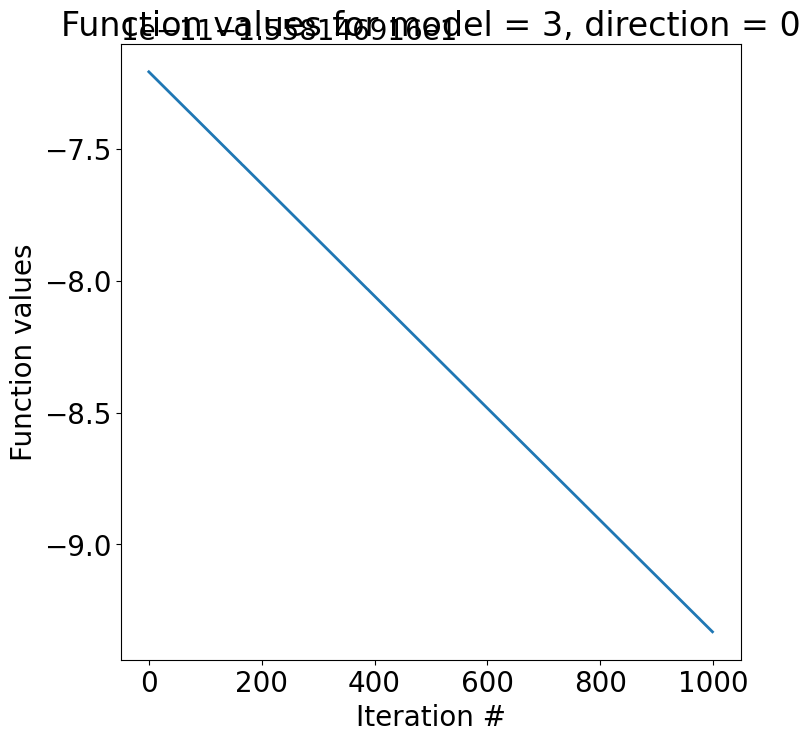

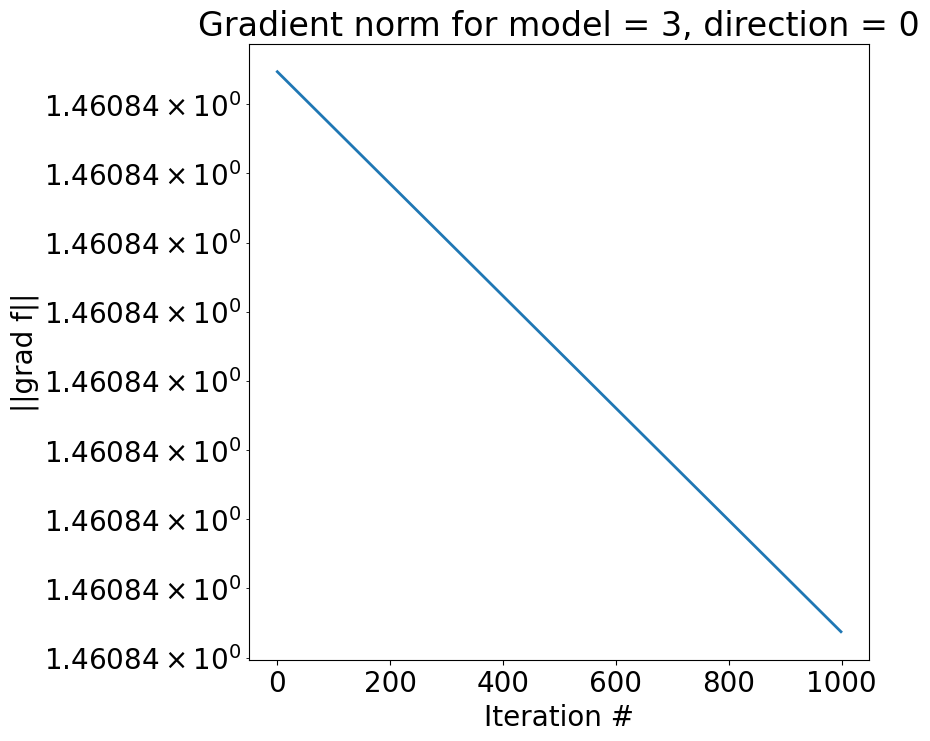

Initially, f =  -15.581469160072078 , ||grad f|| =  1.4608366392938223
Result: f = -15.5814691601, ||grad f|| = 1.460837e+00


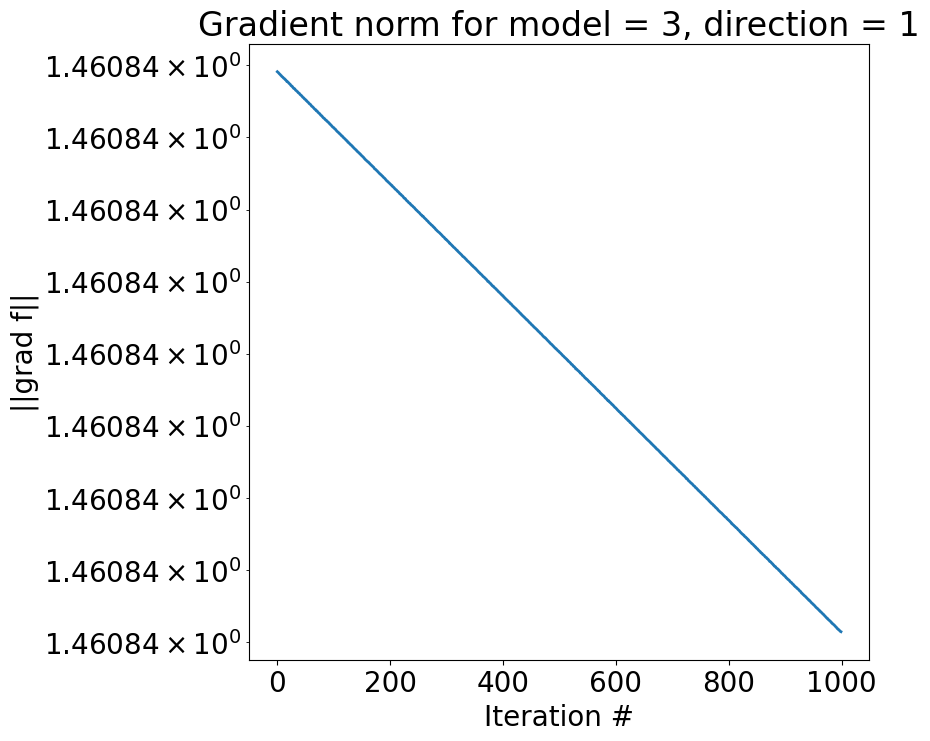

Initially, f =  -15.581469160072078 , ||grad f|| =  1.4608366392938223
Result: f = -15.5814691601, ||grad f|| = 1.460837e+00


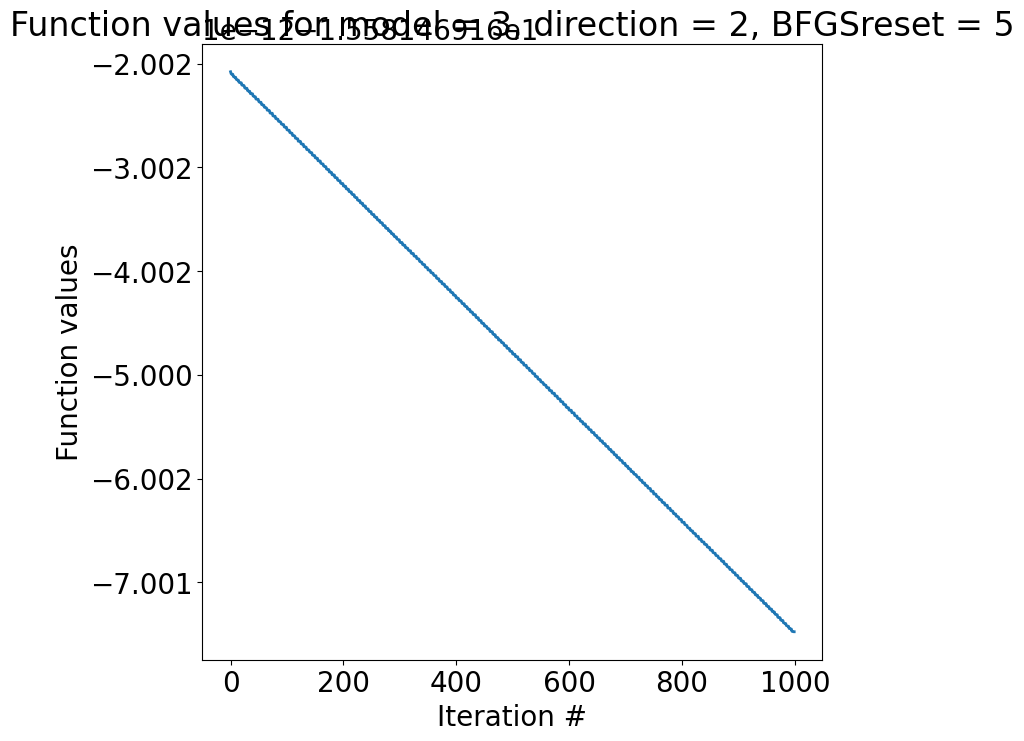

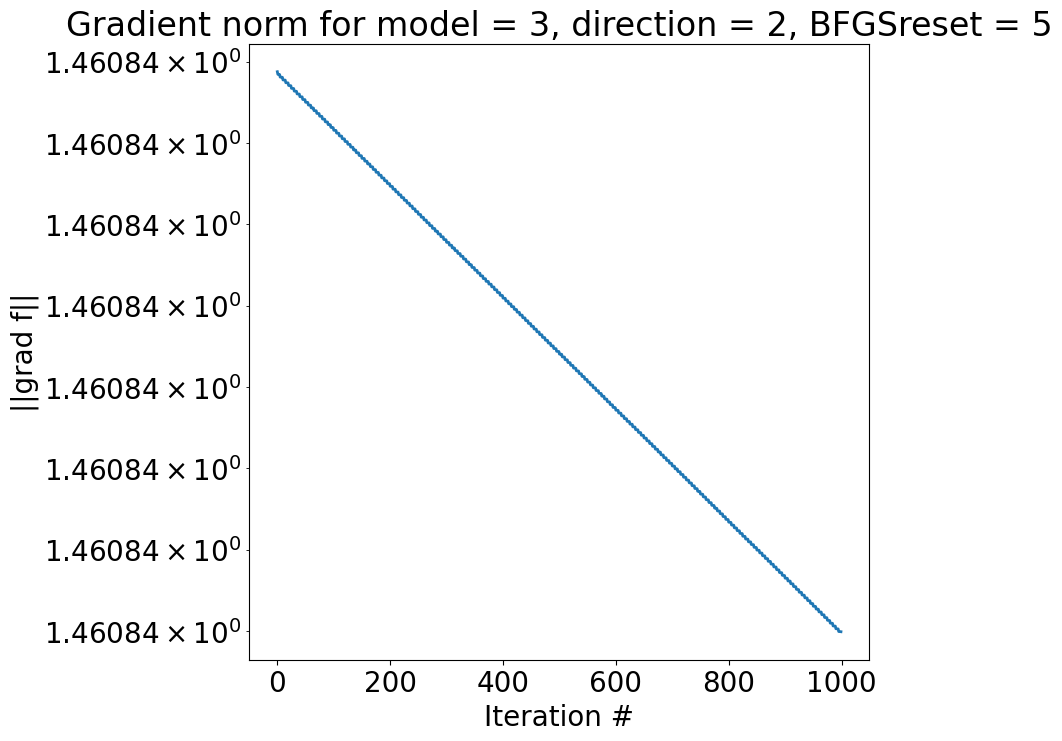

Initially, f =  -15.581469160072078 , ||grad f|| =  1.4608366392938223
Result: f = -15.5814691601, ||grad f|| = 1.460837e+00


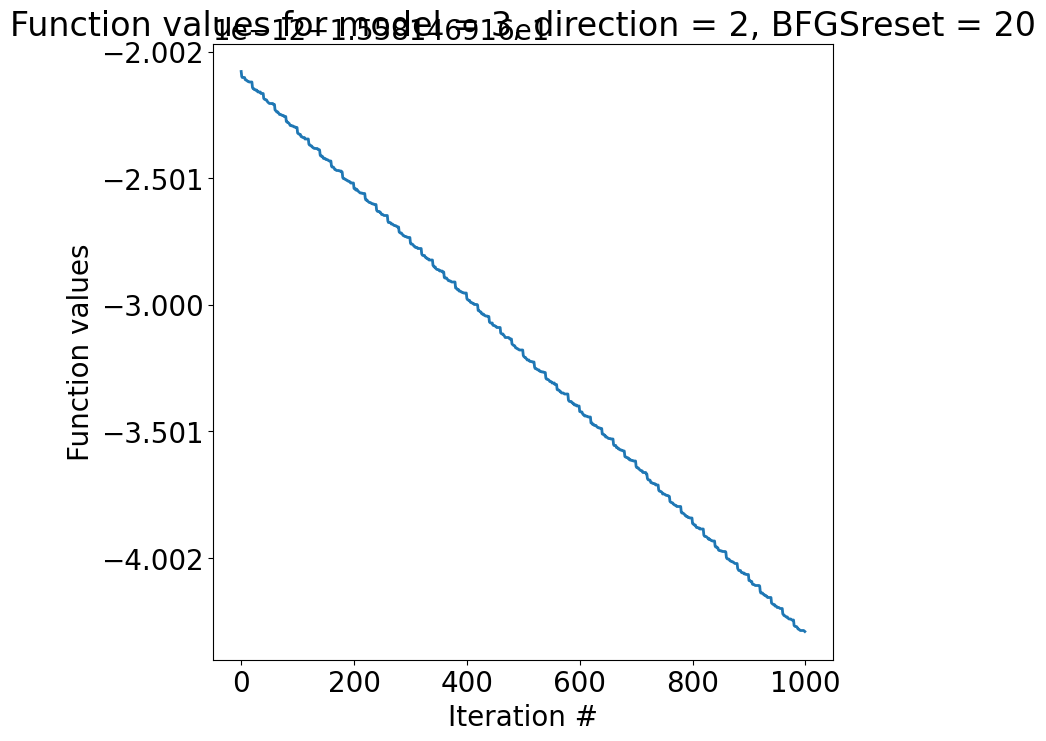

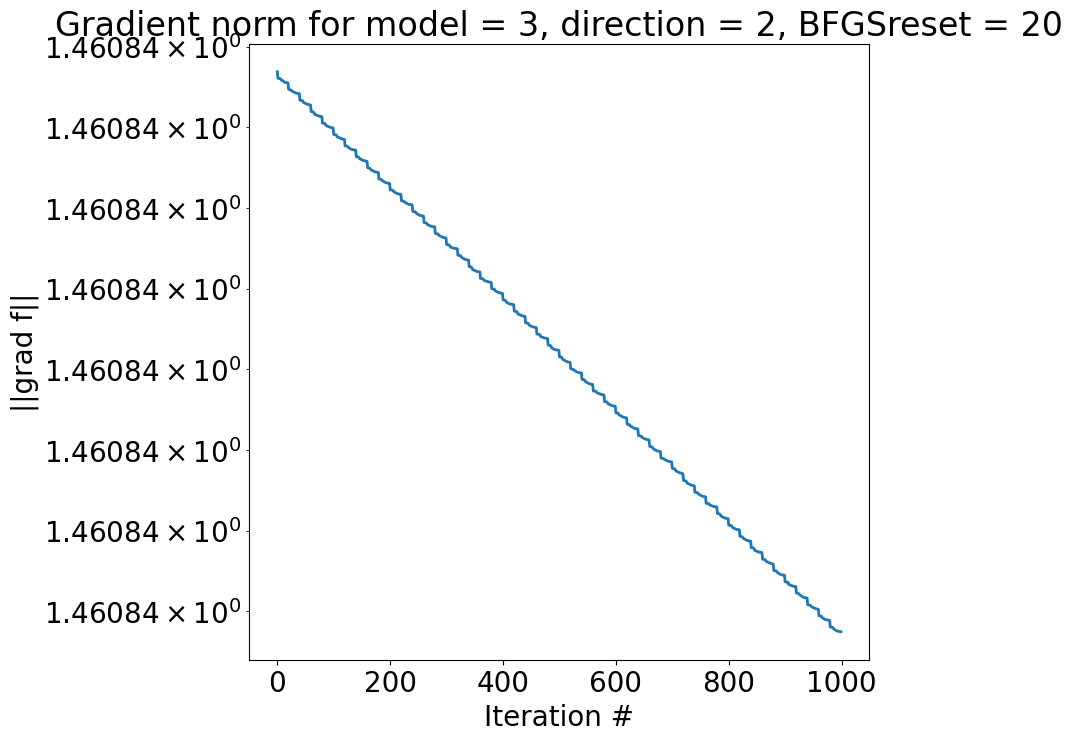

Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: f = -15.5222101700, ||grad f|| = 1.285438e+00


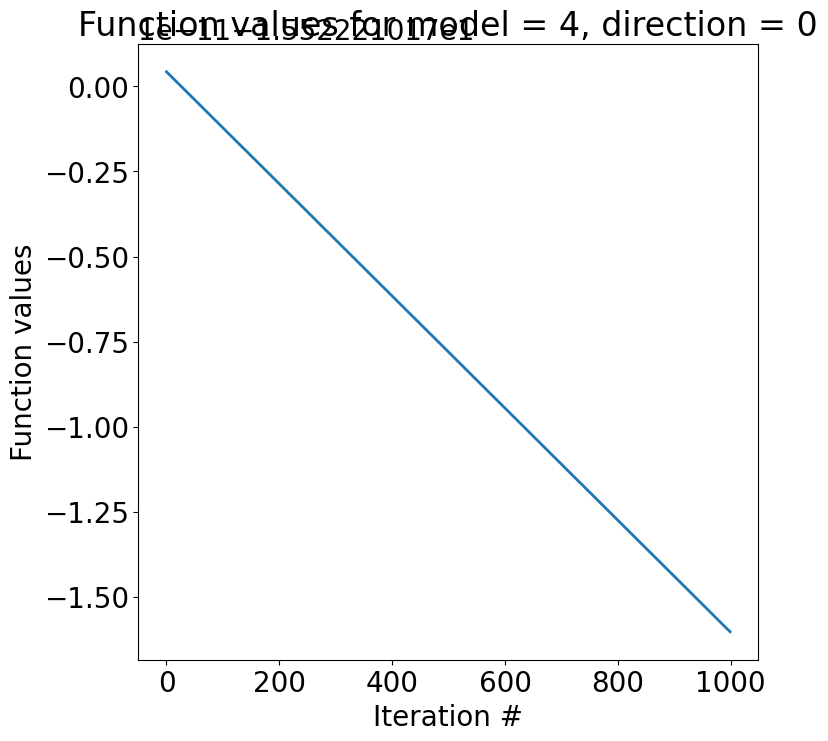

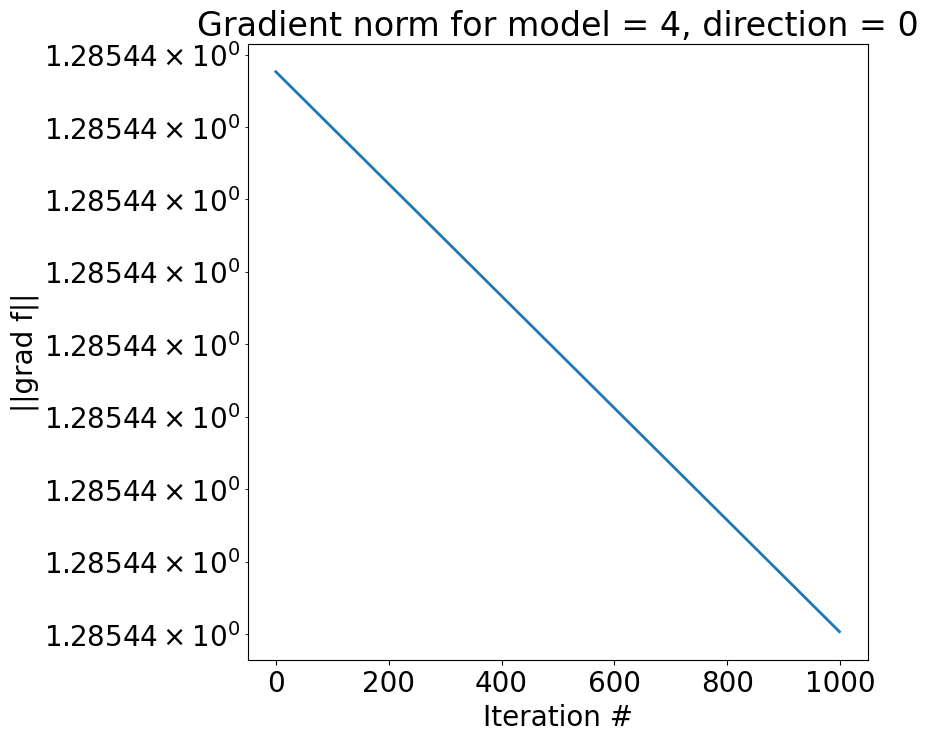

Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: f = -15.5222101700, ||grad f|| = 1.285438e+00


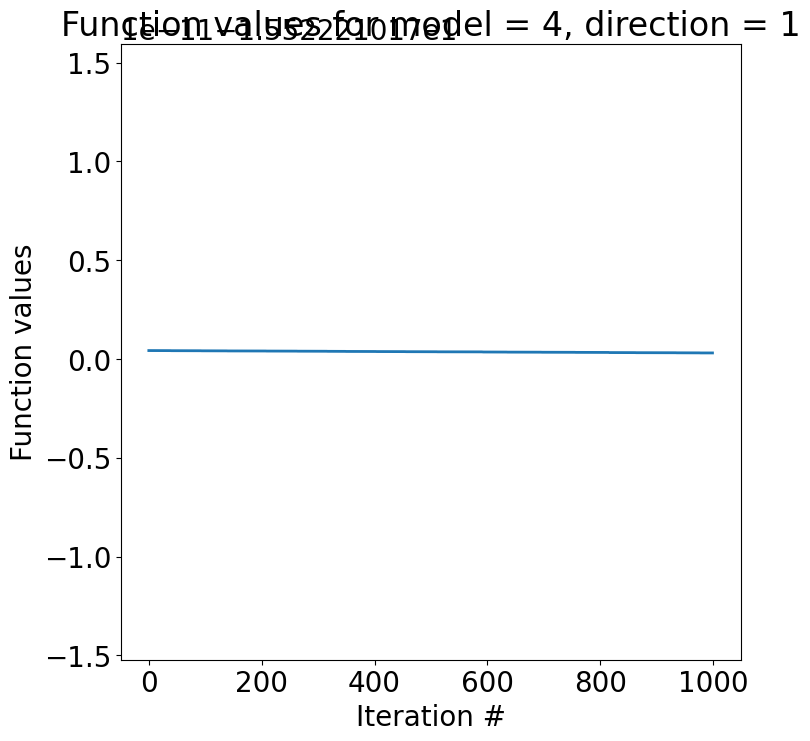

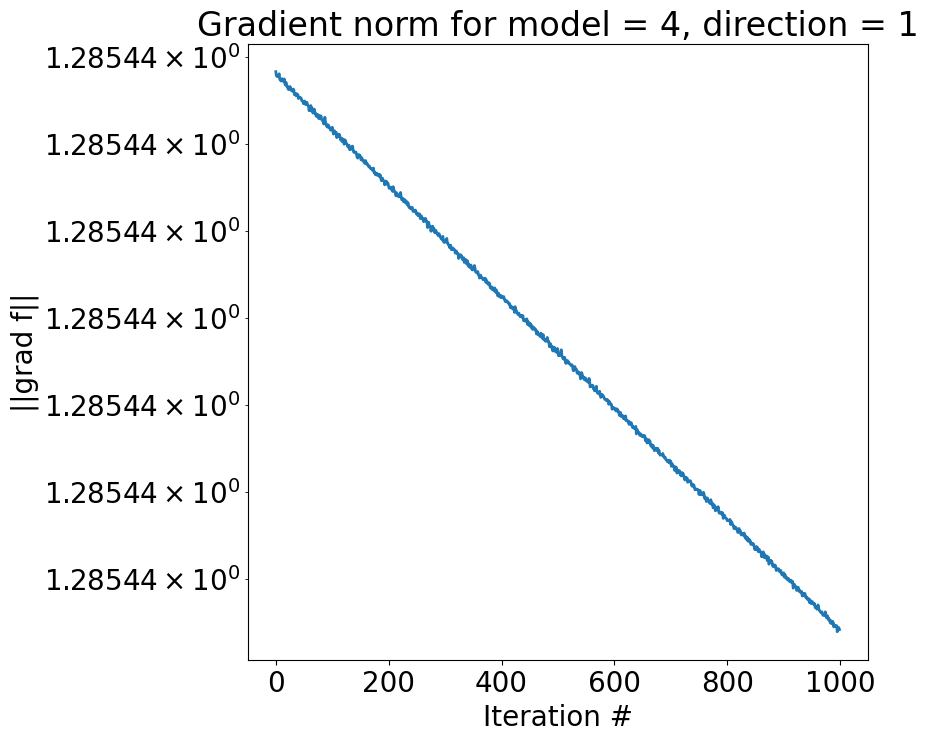

Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: f = -15.5222101700, ||grad f|| = 1.285438e+00


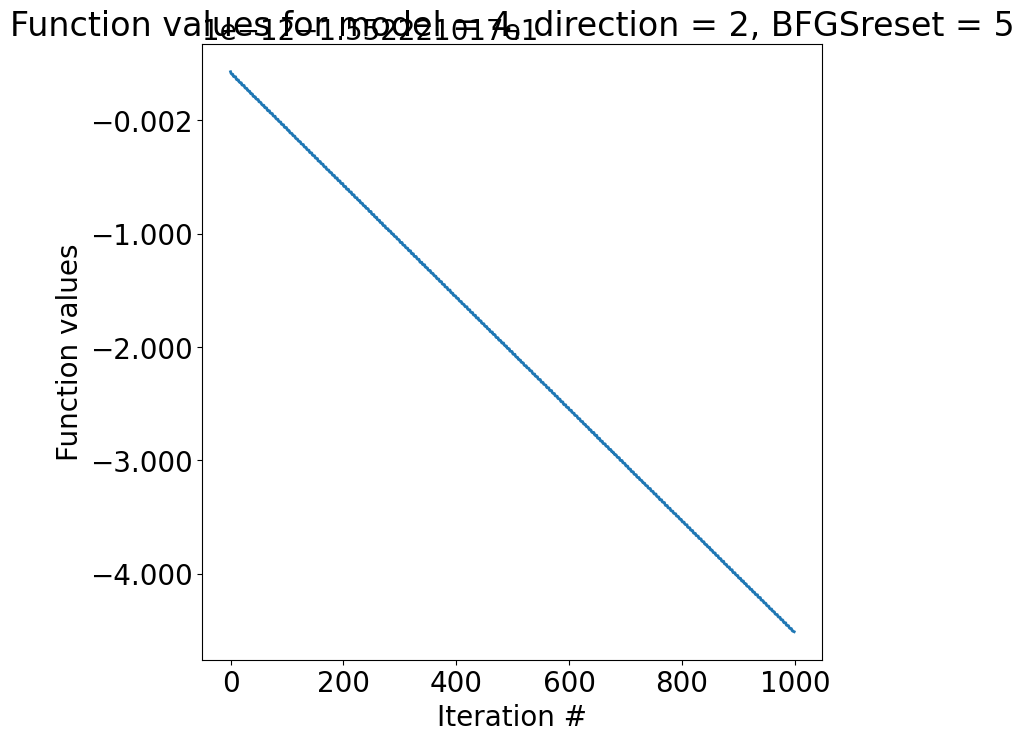

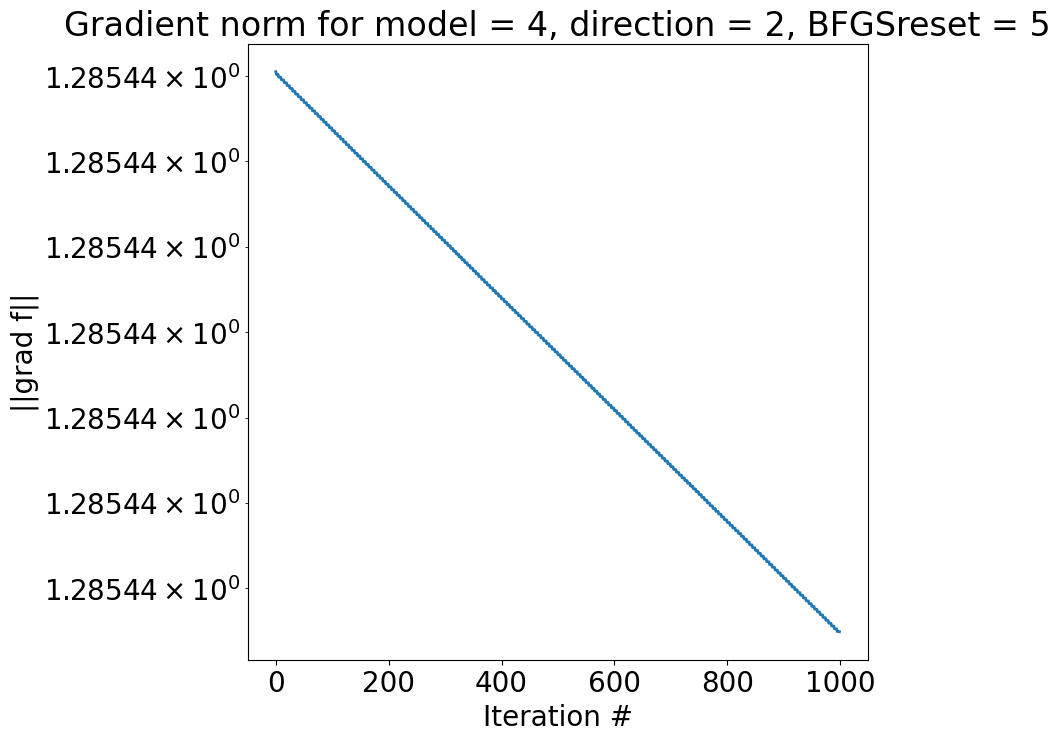

Initially, f =  -15.522210169999571 , ||grad f|| =  1.2854375635525659
Result: f = -15.5222101700, ||grad f|| = 1.285438e+00


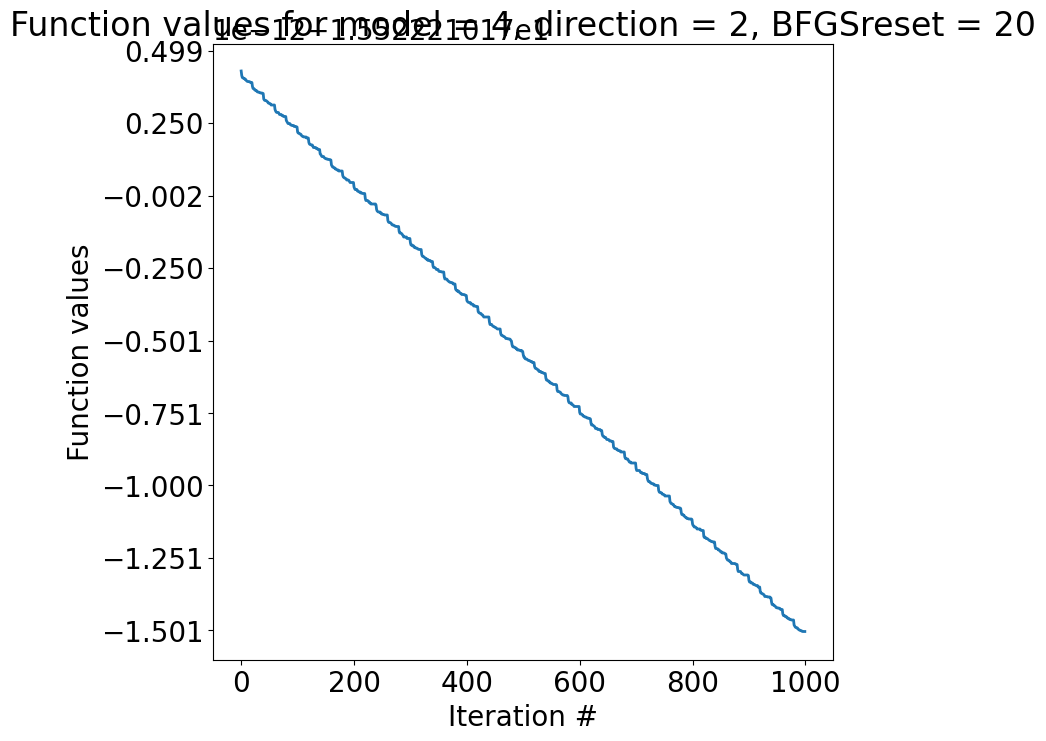

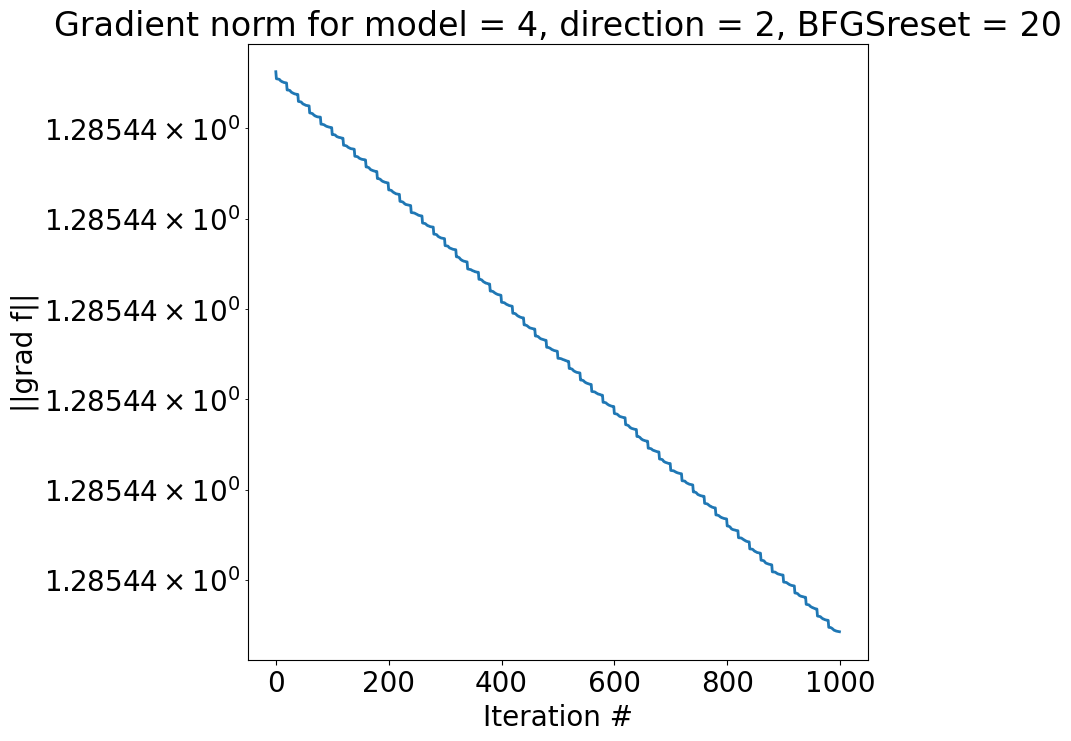

Initially, f =  -5.4500467182847085 , ||grad f|| =  5.450523692439162
Result: f = -5.4500467186, ||grad f|| = 5.450524e+00


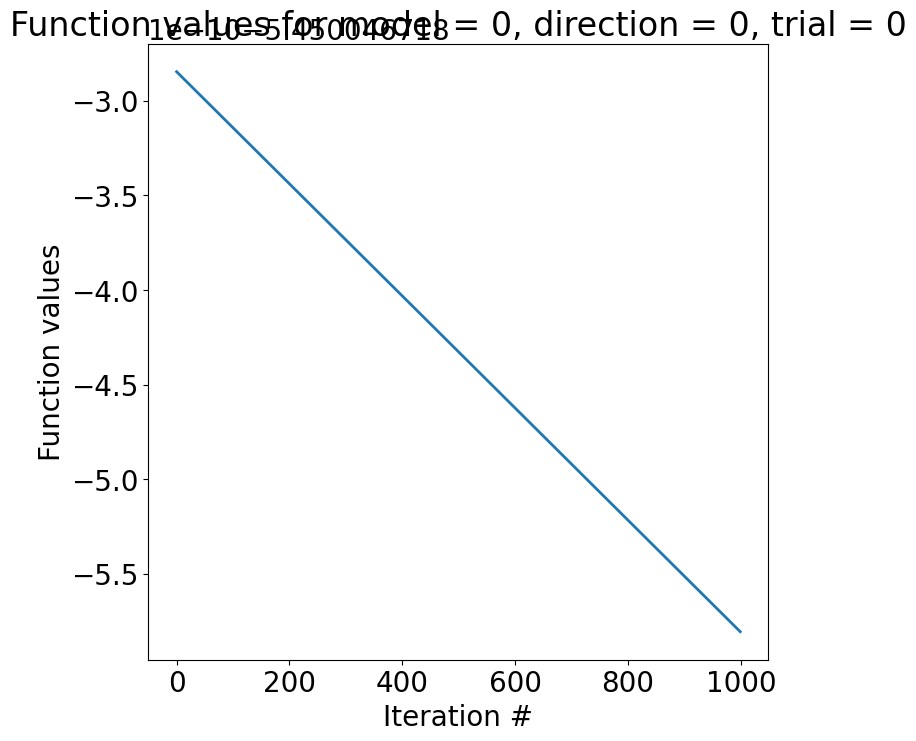

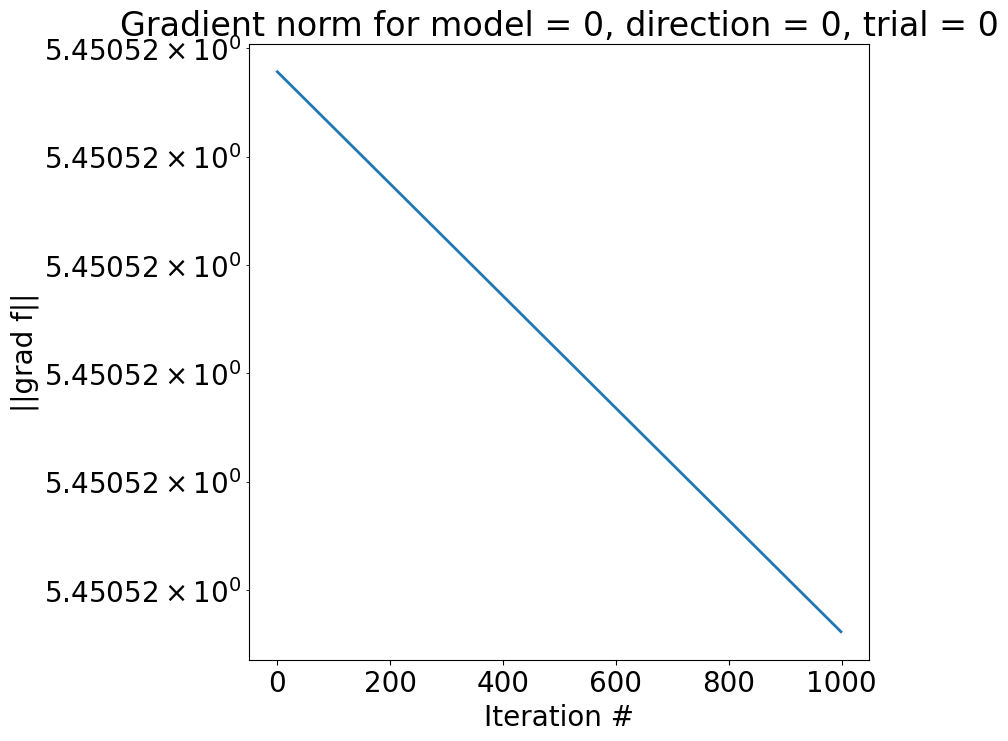

Initially, f =  -5.4500467182847085 , ||grad f|| =  5.450523692439162
Result: f = -5.4500467186, ||grad f|| = 5.450524e+00


Initially, f =  -5.4500467182847085 , ||grad f|| =  5.450523692439162
Result: f = -5.4500467194, ||grad f|| = 5.450524e+00


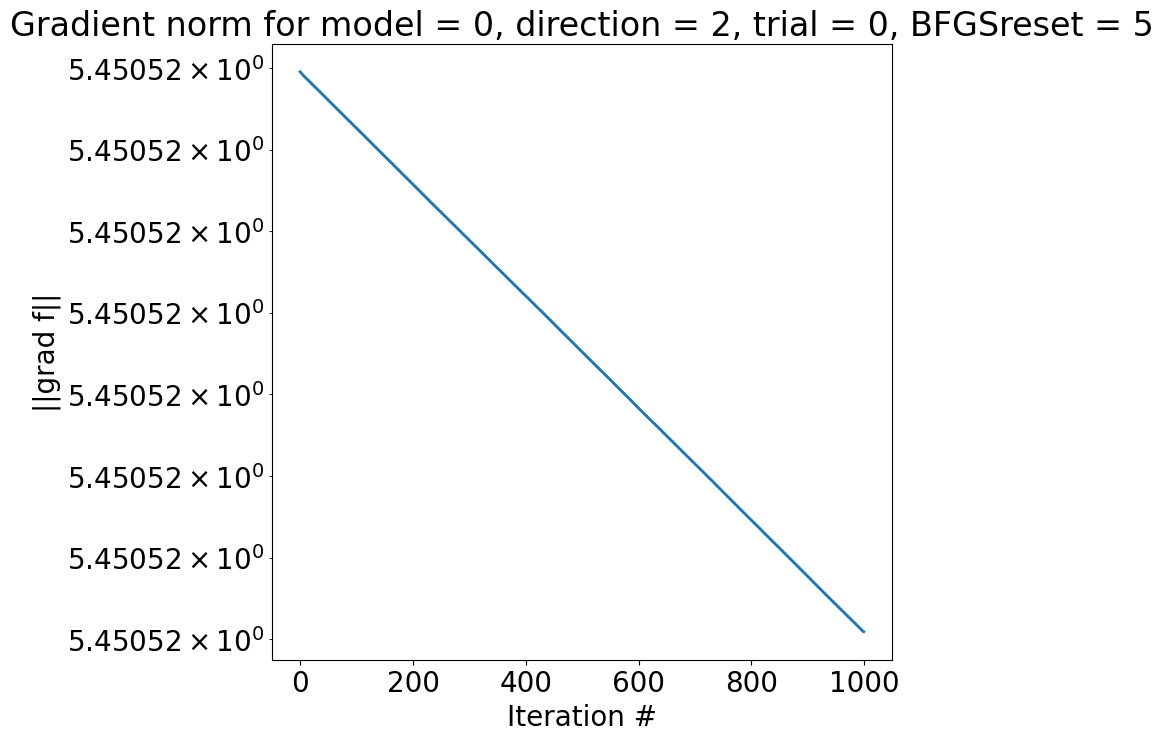

Initially, f =  -5.4500467182847085 , ||grad f|| =  5.450523692439162
Result: f = -5.4500469467, ||grad f|| = 5.450523e+00


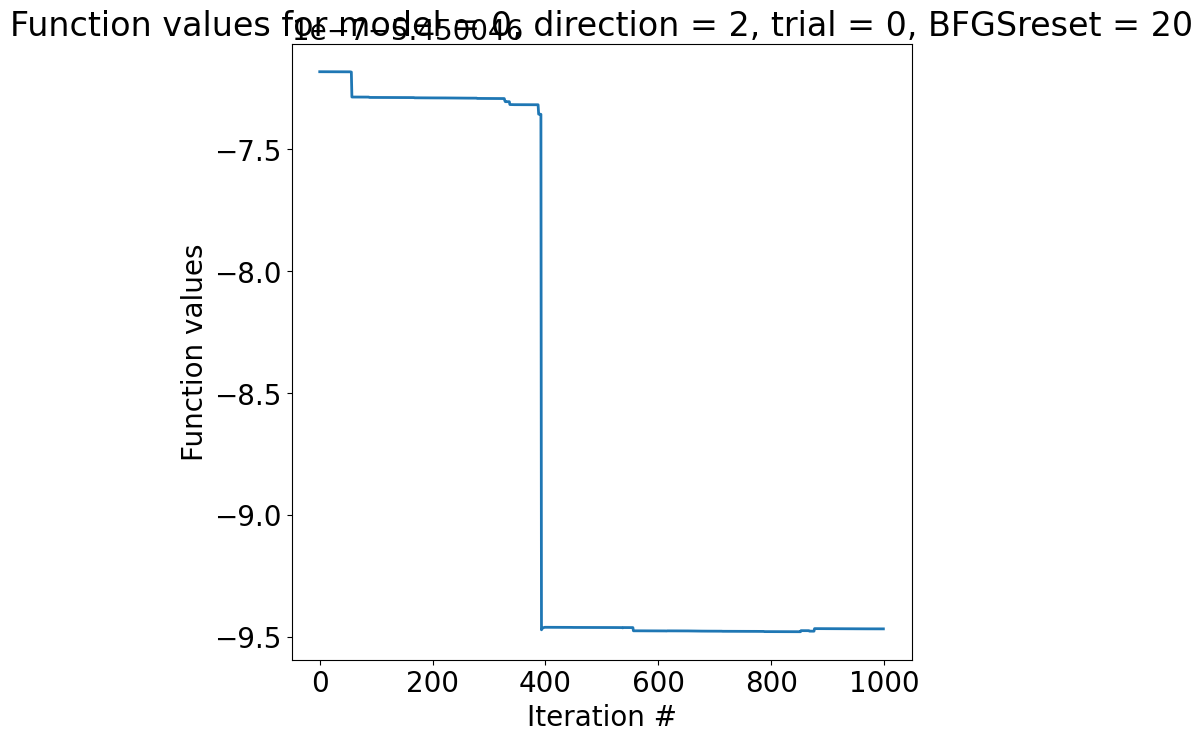

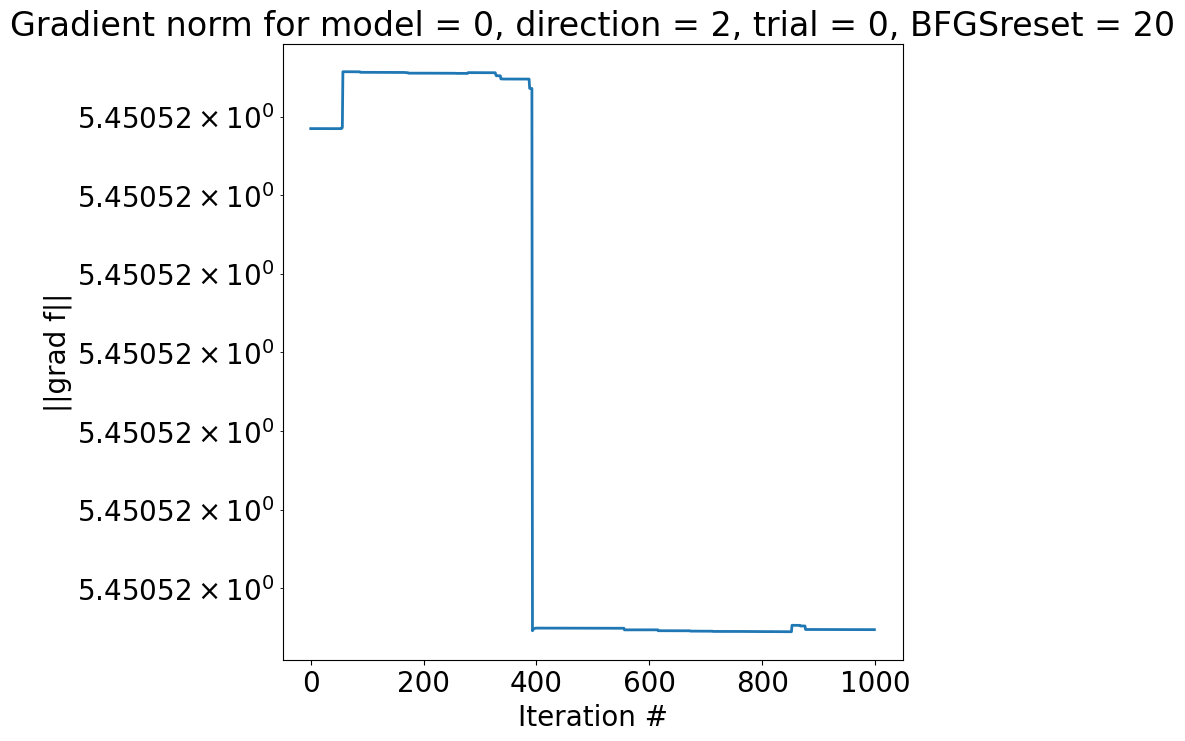

Initially, f =  -7.520214857694841 , ||grad f|| =  12.424246251297255
Result: f = -7.5202148592, ||grad f|| = 1.242425e+01


Initially, f =  -7.520214857694841 , ||grad f|| =  12.424246251297255
Result: f = -7.5202148592, ||grad f|| = 1.242425e+01


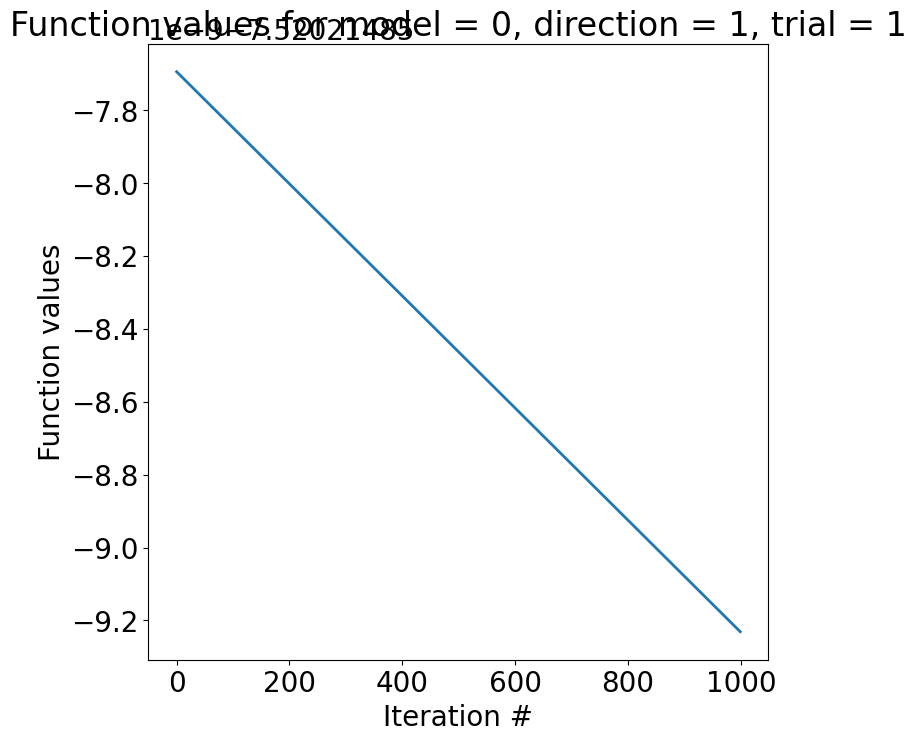

Initially, f =  -7.520214857694841 , ||grad f|| =  12.424246251297255
Result: f = -7.5202149108, ||grad f|| = 1.242425e+01


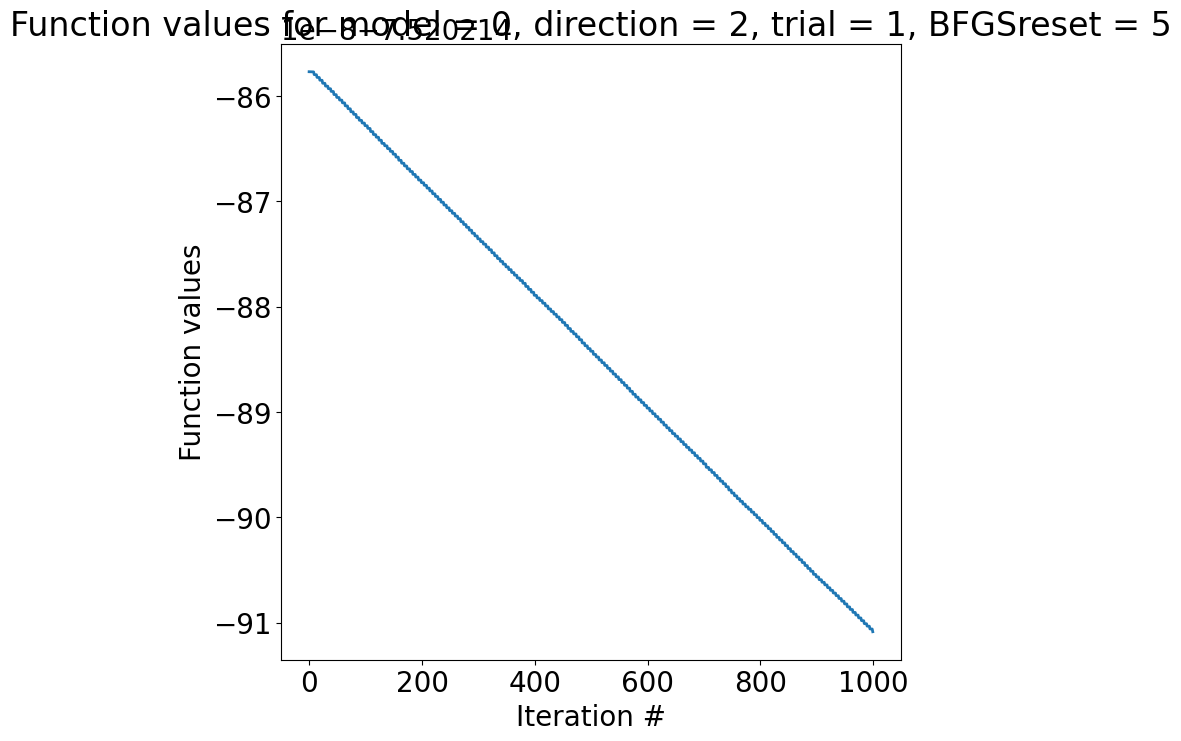

Initially, f =  -7.520214857694841 , ||grad f|| =  12.424246251297255
Result: f = -7.5202148710, ||grad f|| = 1.242425e+01


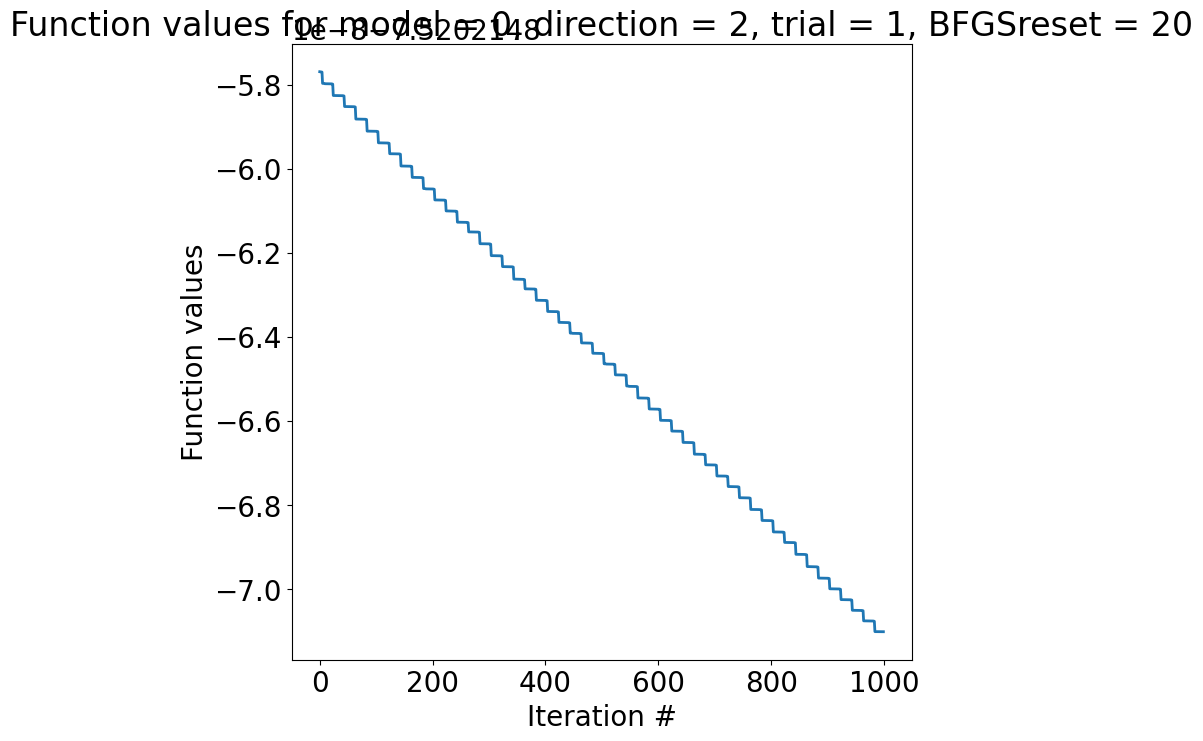

Initially, f =  -7.3104297391280655 , ||grad f|| =  9.349449279844844
Result: f = -7.3104297400, ||grad f|| = 9.349449e+00


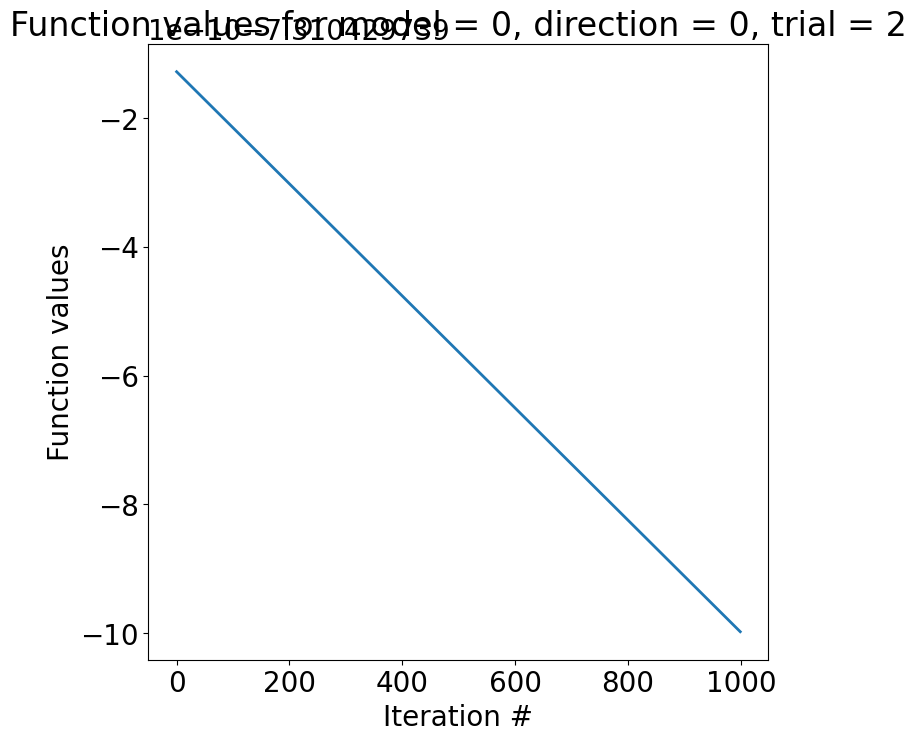

Initially, f =  -7.3104297391280655 , ||grad f|| =  9.349449279844844
Result: f = -7.3104297400, ||grad f|| = 9.349449e+00


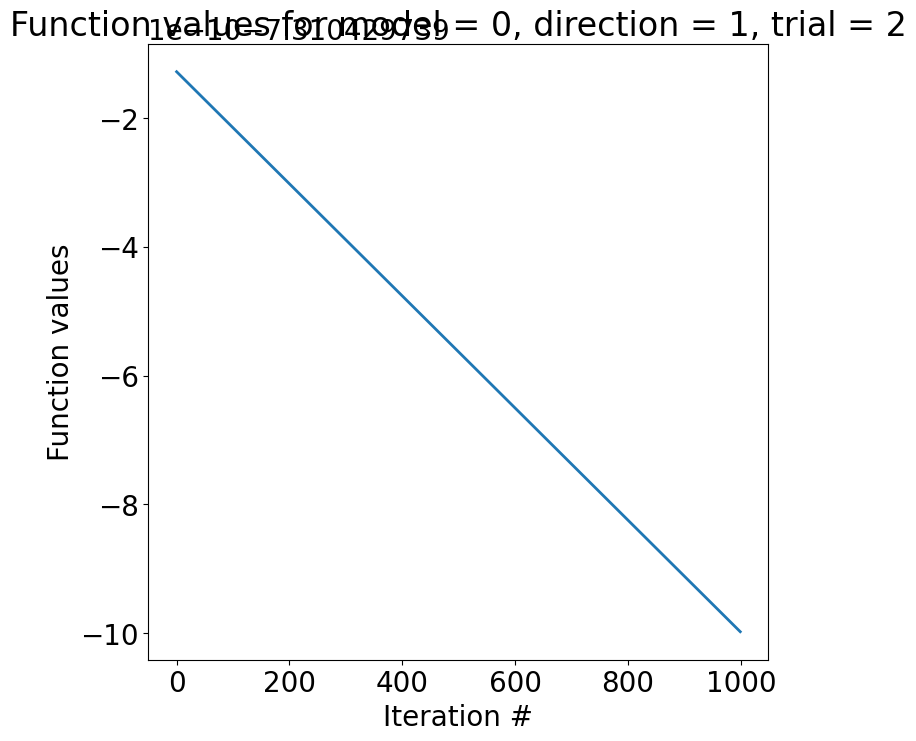

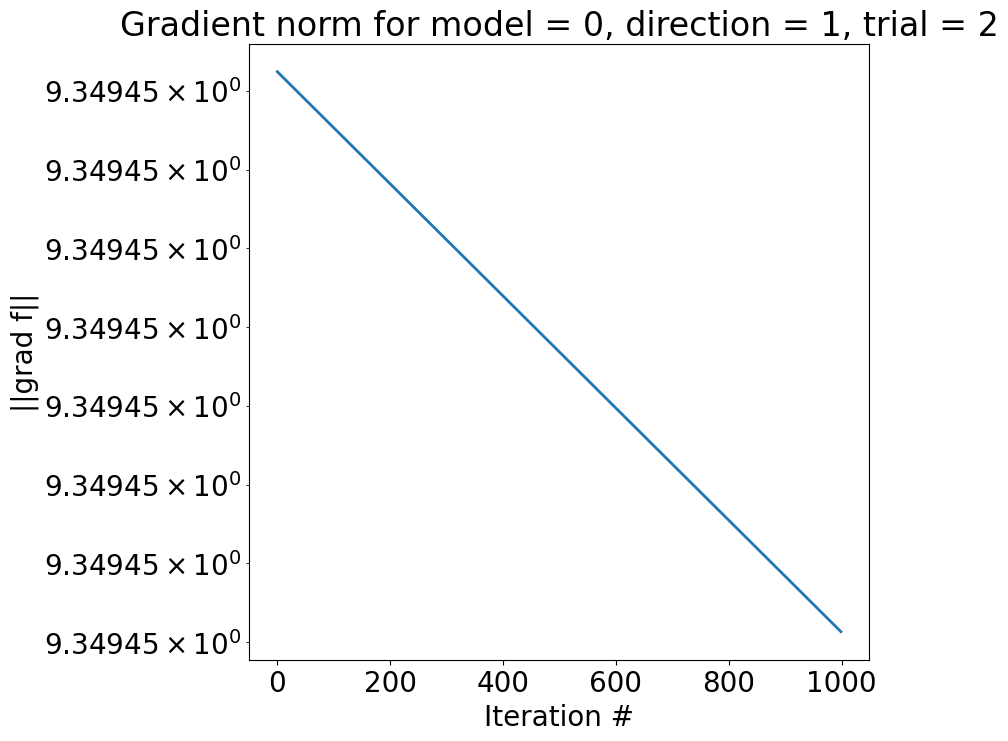

Initially, f =  -7.3104297391280655 , ||grad f|| =  9.349449279844844
Result: f = -7.3104297661, ||grad f|| = 9.349449e+00


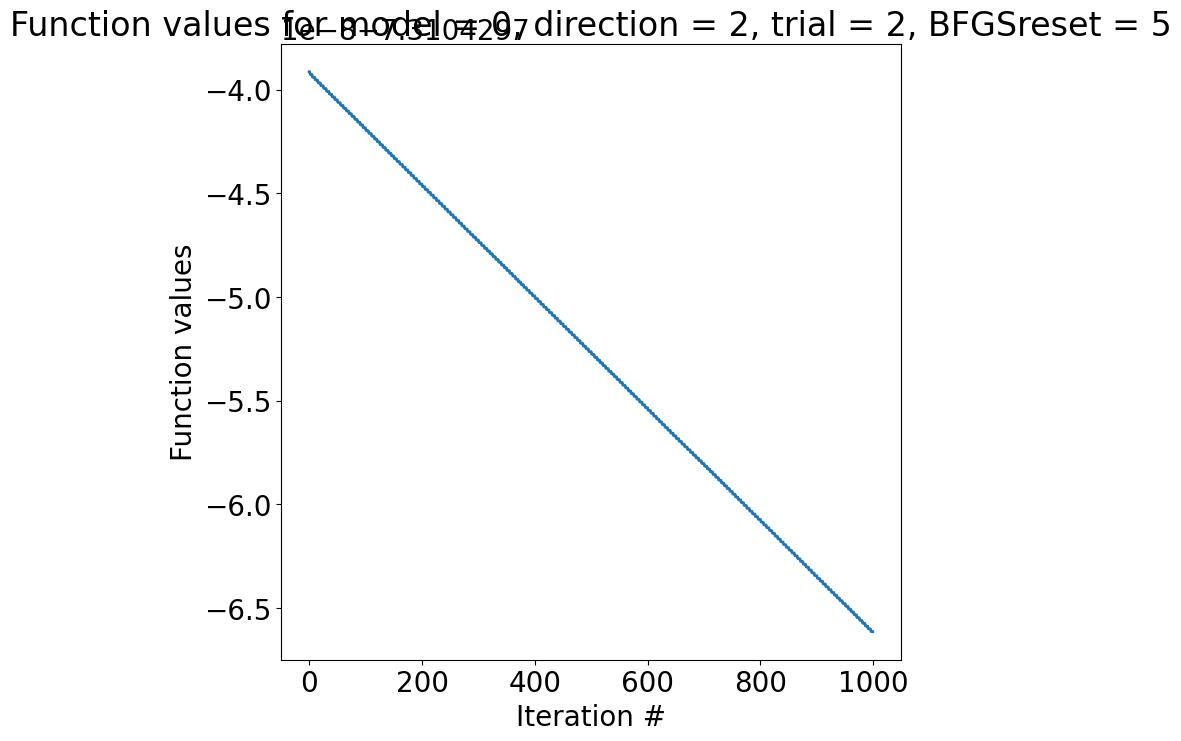

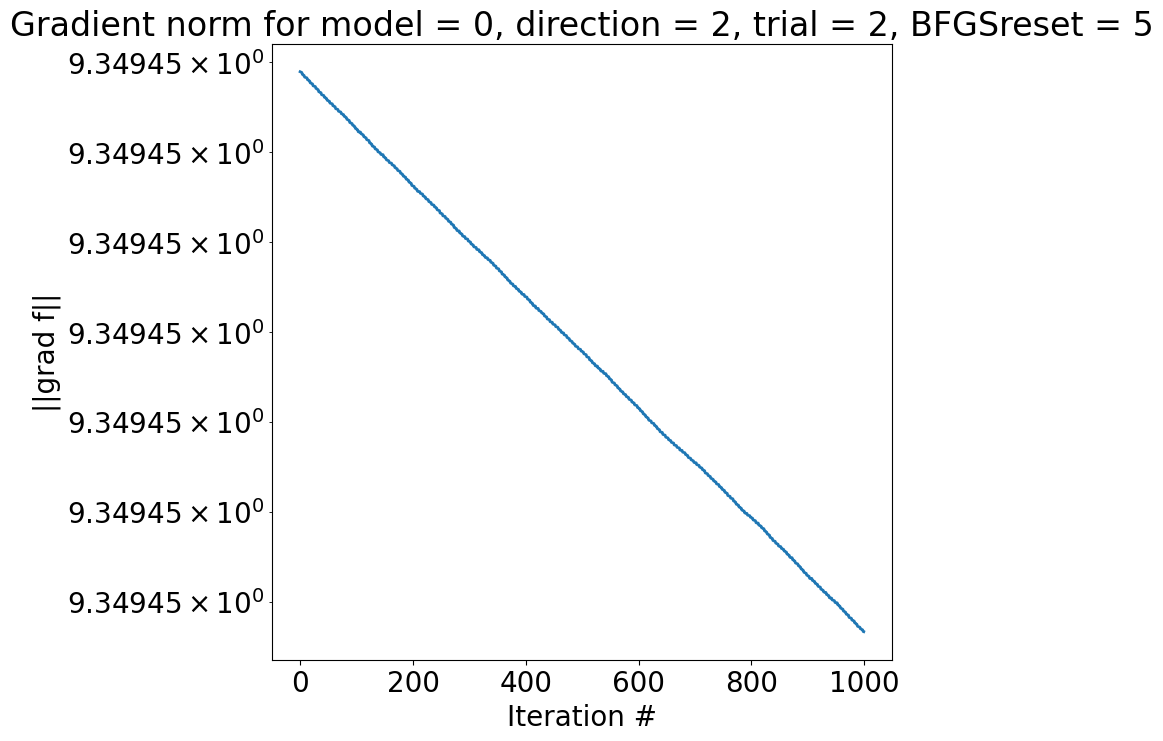

Initially, f =  -7.3104297391280655 , ||grad f|| =  9.349449279844844
Result: f = -7.3104297663, ||grad f|| = 9.349449e+00


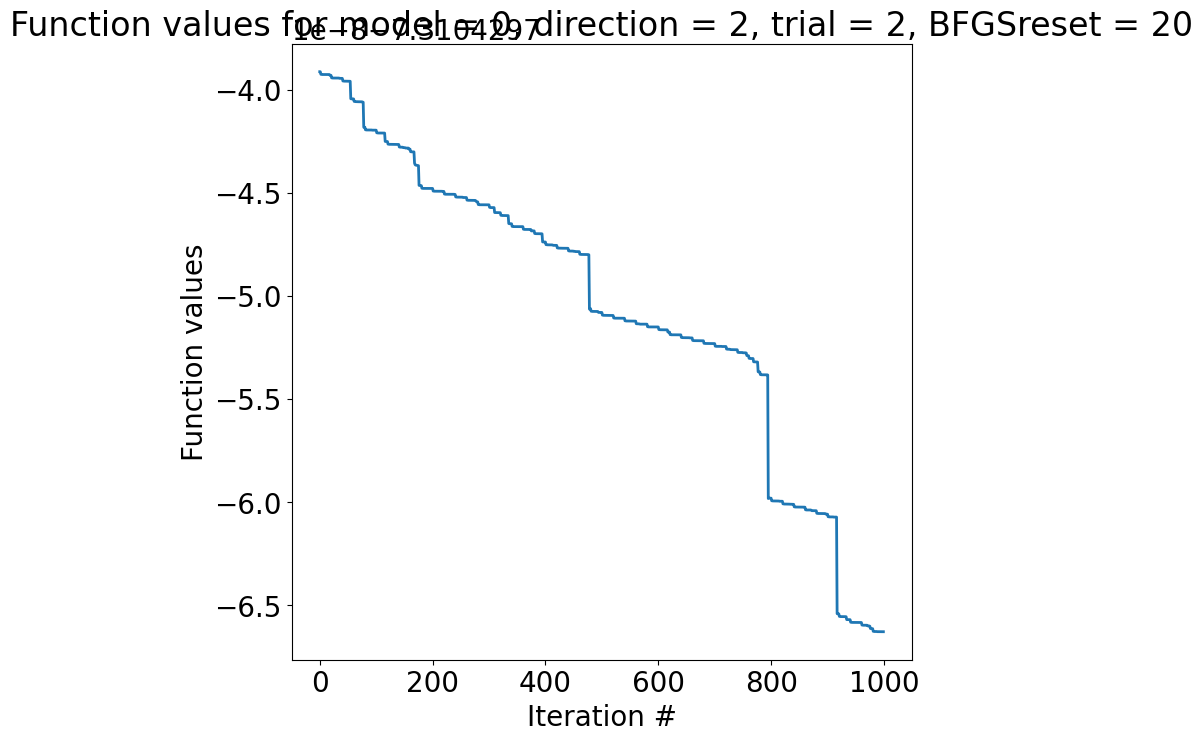

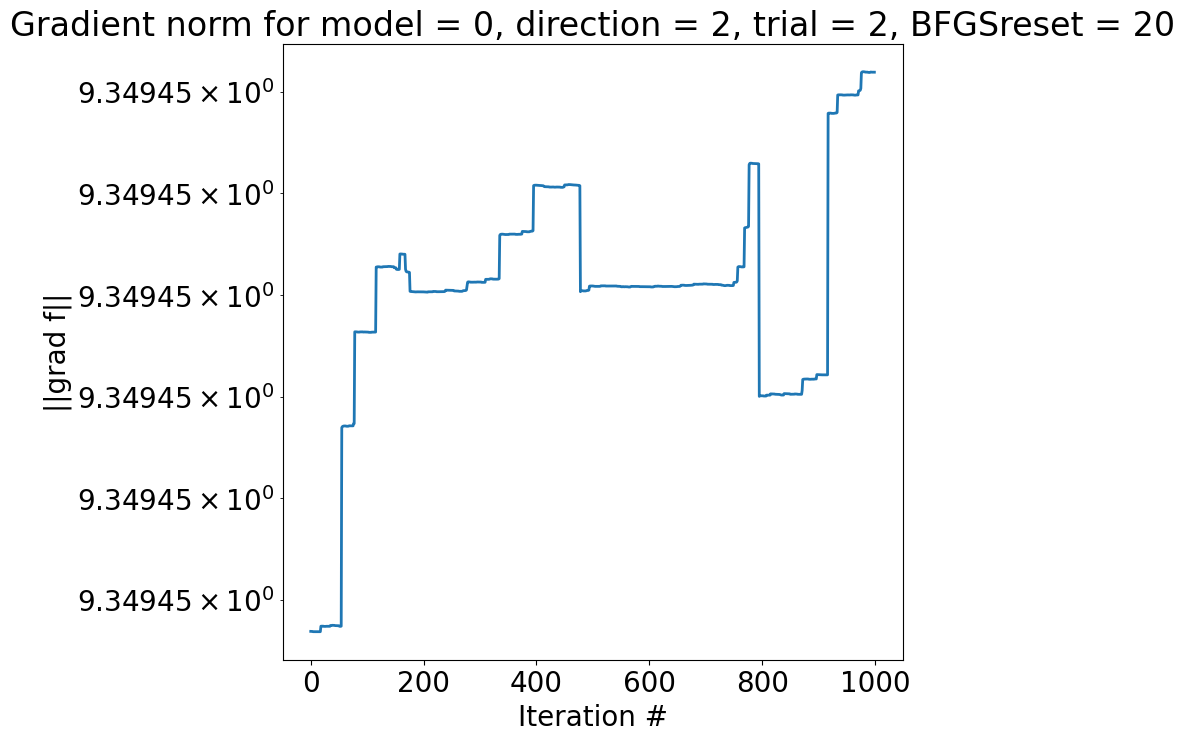

Initially, f =  1.2371101358453508e+16 , ||grad f|| =  2.900360390121314e+18
Result: f = 50584382.4301571250, ||grad f|| = 1.432222e+09


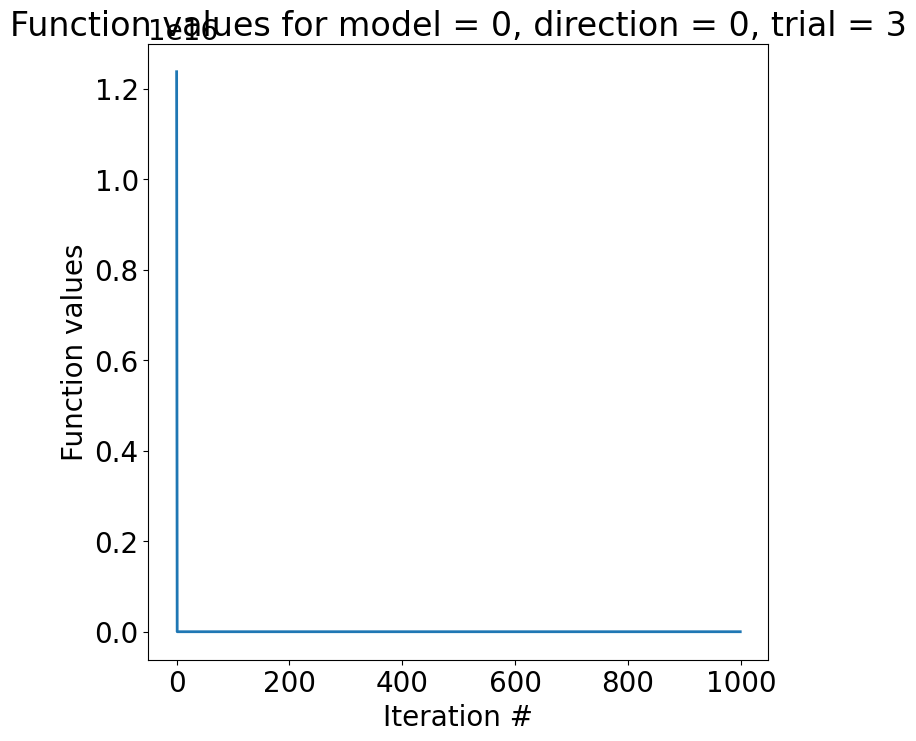

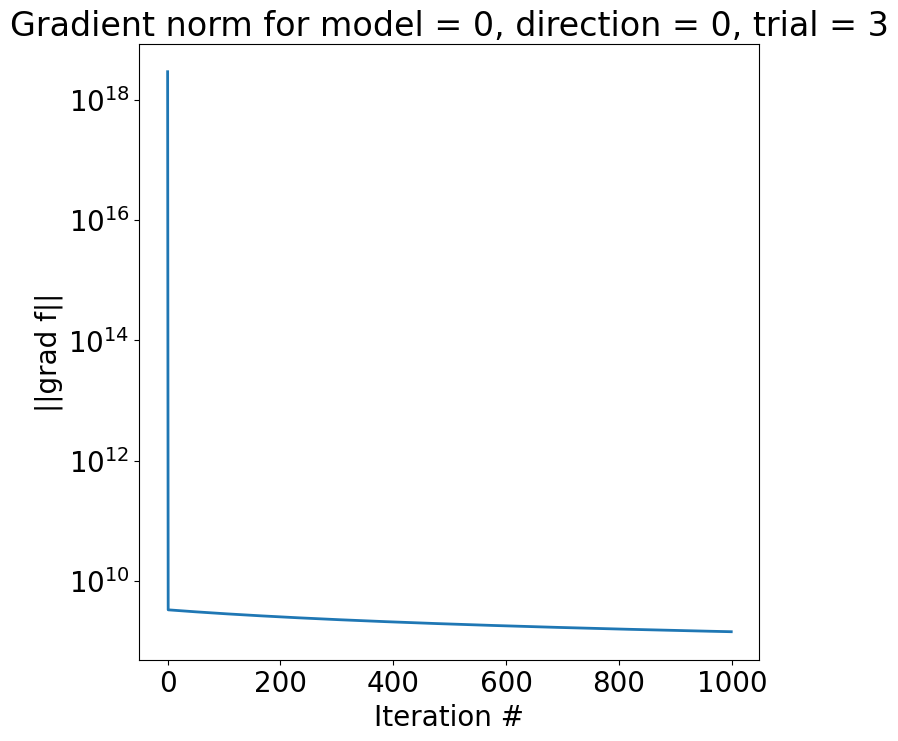

Initially, f =  1.2371101358453508e+16 , ||grad f|| =  2.900360390121314e+18
Result: f = 50584382.4301571250, ||grad f|| = 1.432222e+09


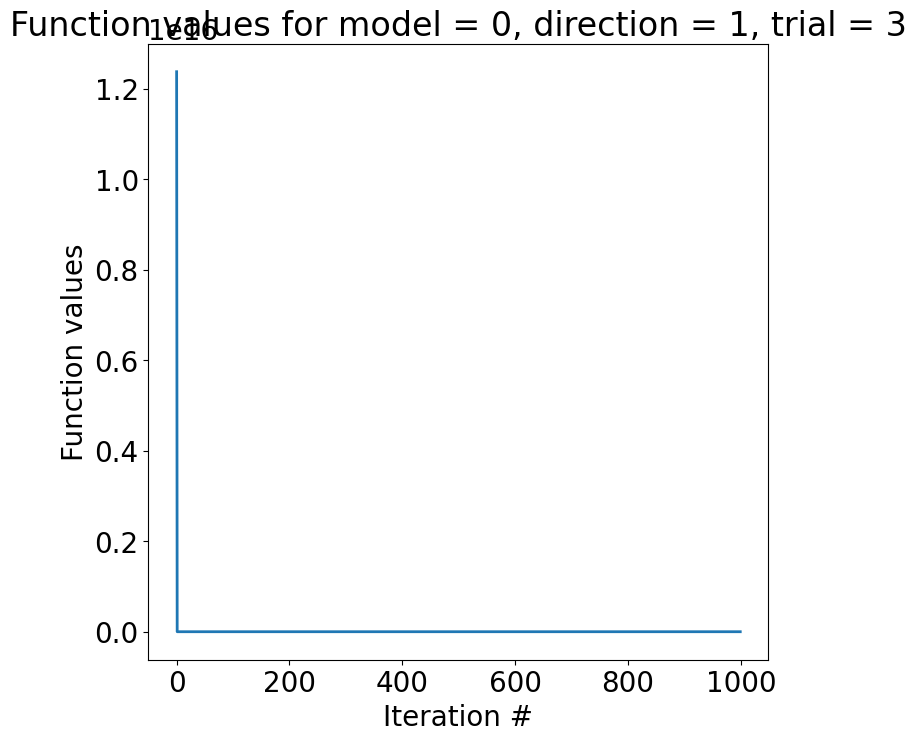

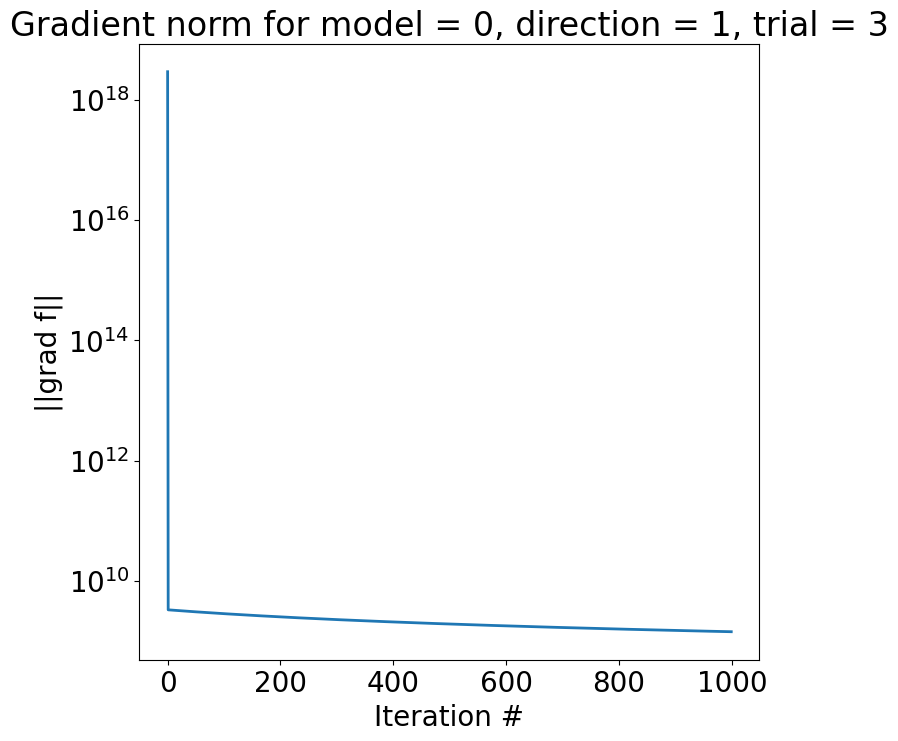

Initially, f =  1.2371101358453508e+16 , ||grad f|| =  2.900360390121314e+18
Result: f = 76217128.3288552761, ||grad f|| = 2.513957e+09


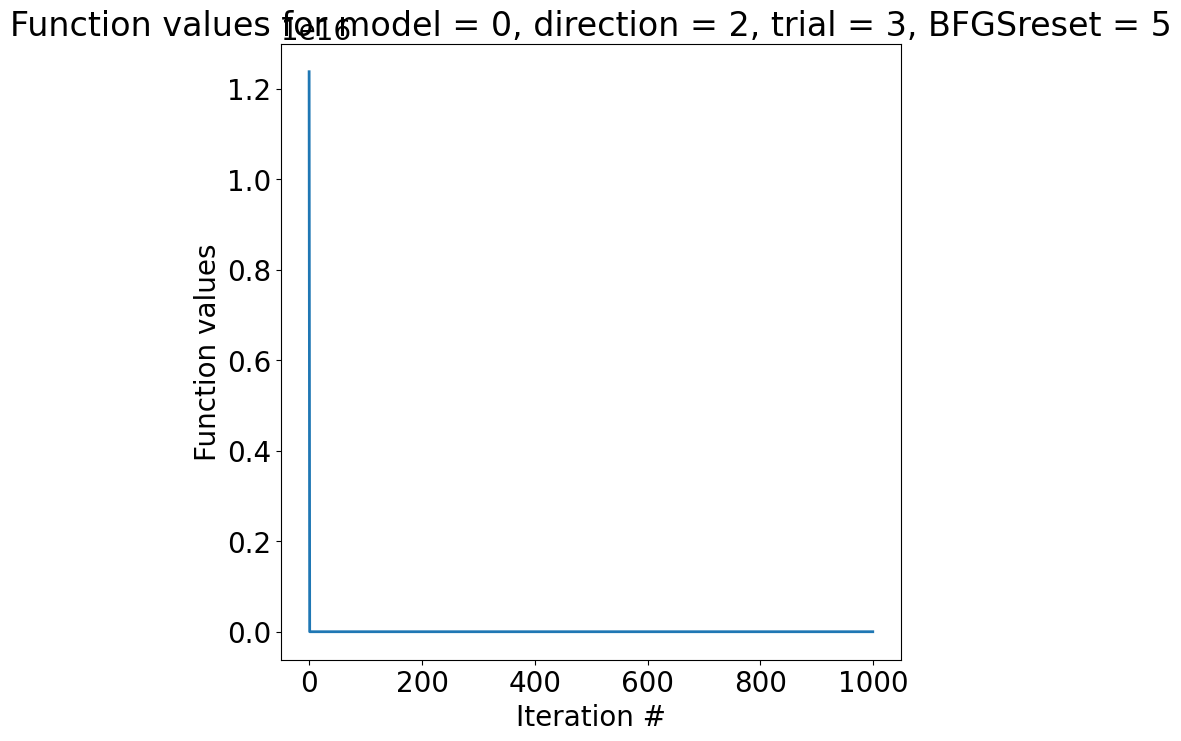

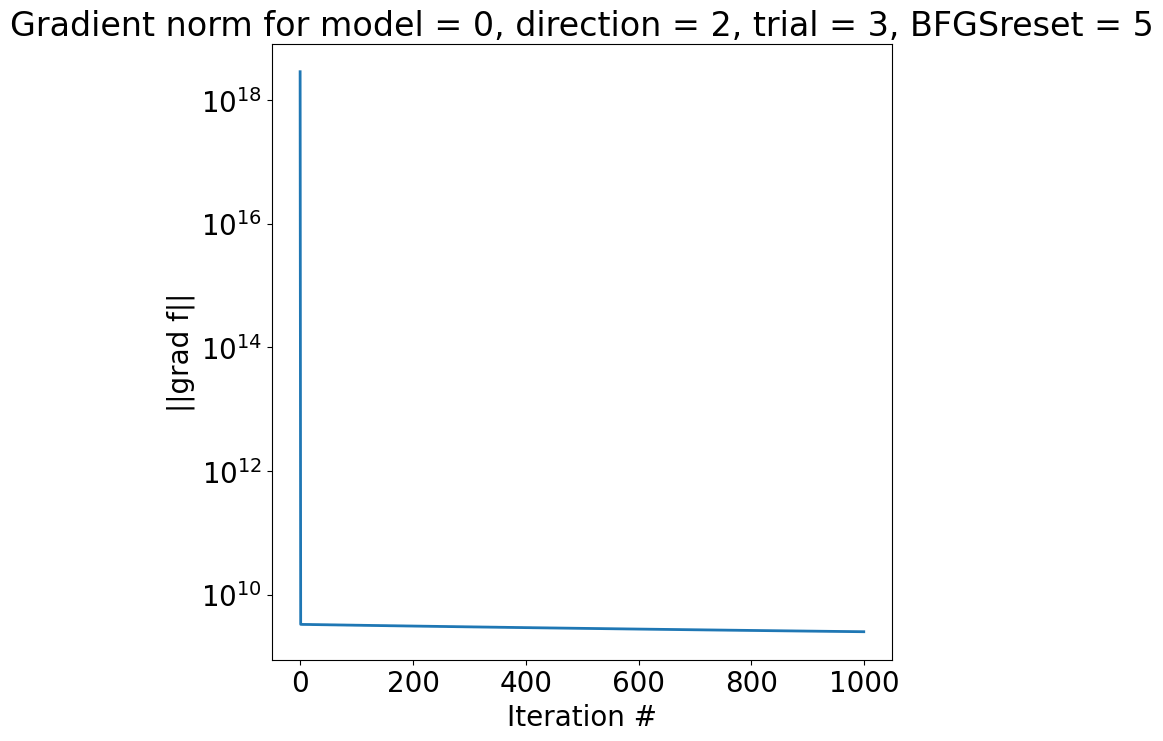

Initially, f =  1.2371101358453508e+16 , ||grad f|| =  2.900360390121314e+18
Result: f = 89377586.5394398272, ||grad f|| = 3.060444e+09


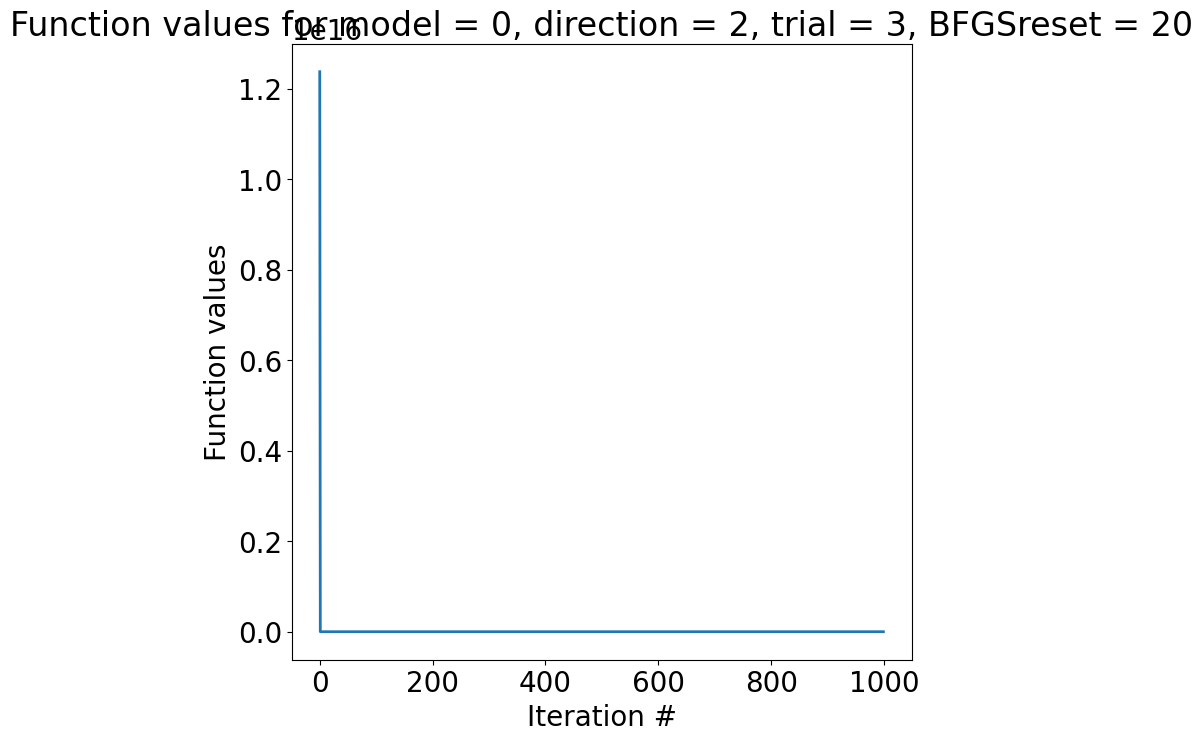

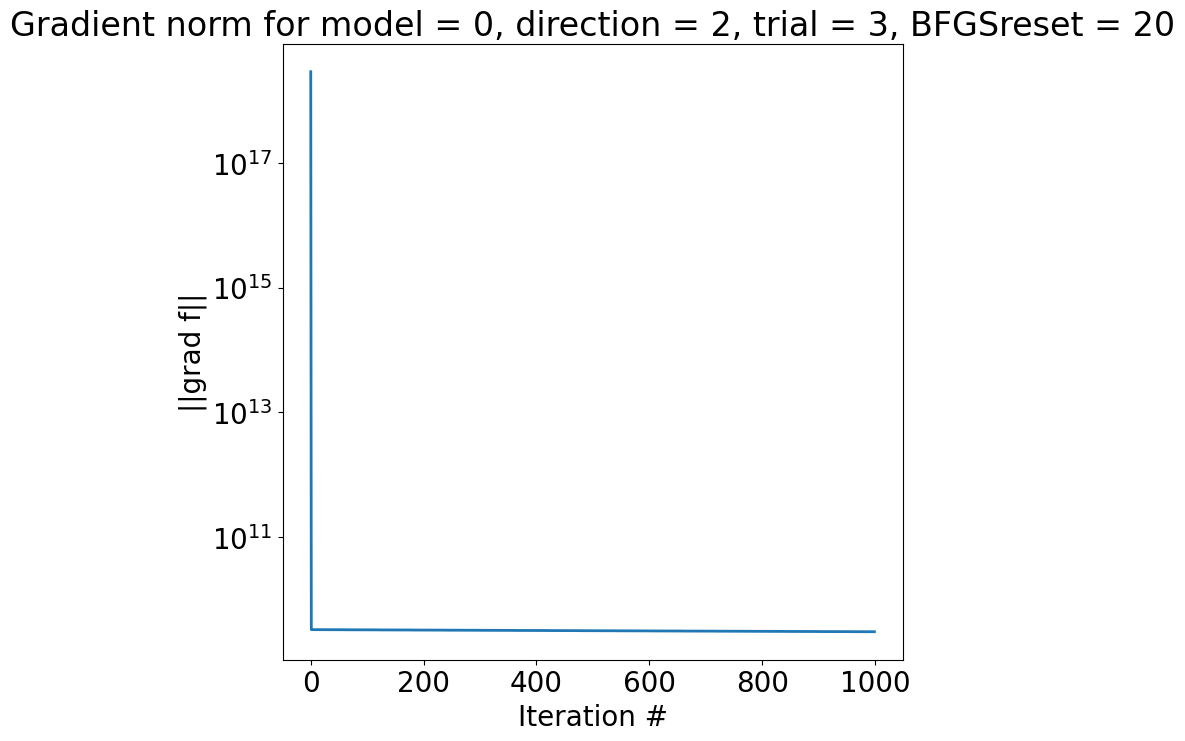

Initially, f =  -7.584463435205812 , ||grad f|| =  6.59155448084648
Result: f = -7.5844634356, ||grad f|| = 6.591554e+00


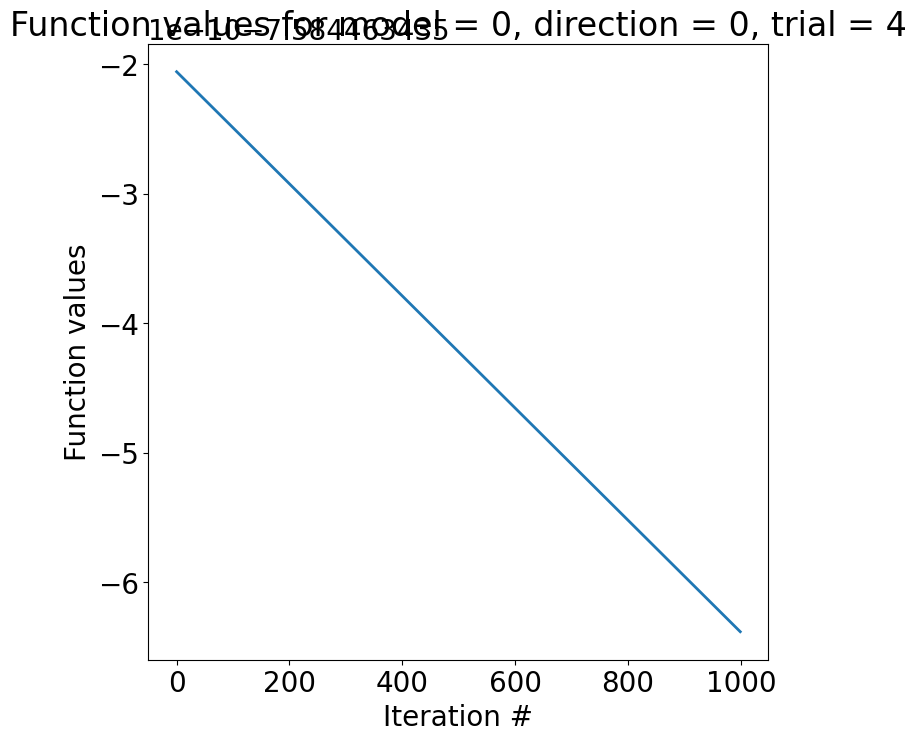

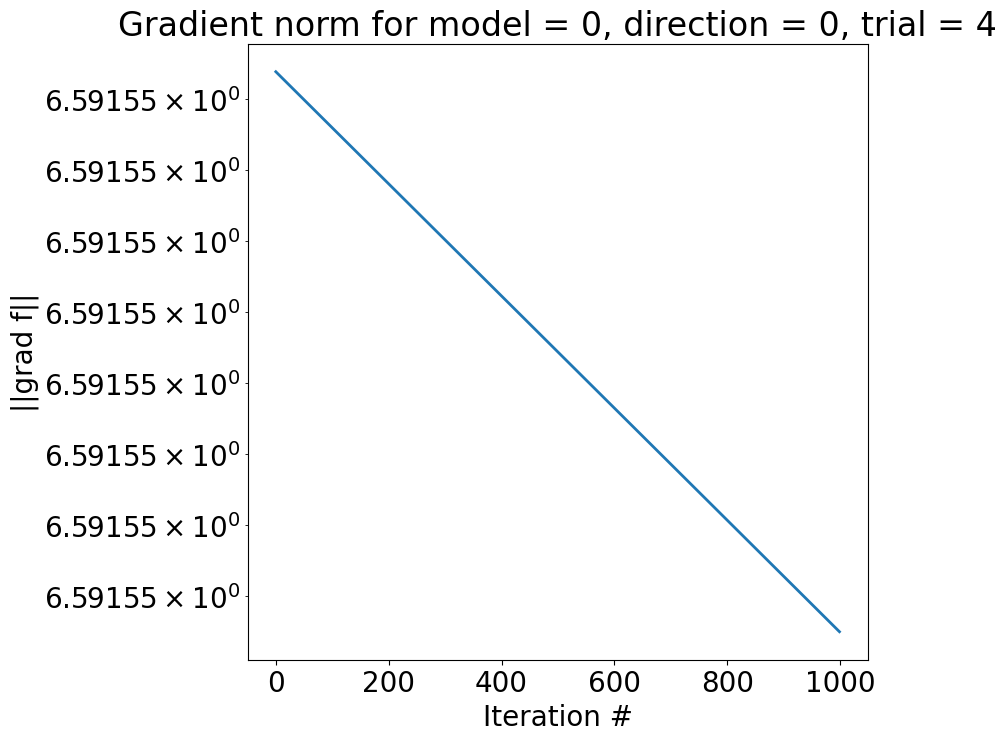

Initially, f =  -7.584463435205812 , ||grad f|| =  6.59155448084648
Result: f = -7.5844634356, ||grad f|| = 6.591554e+00


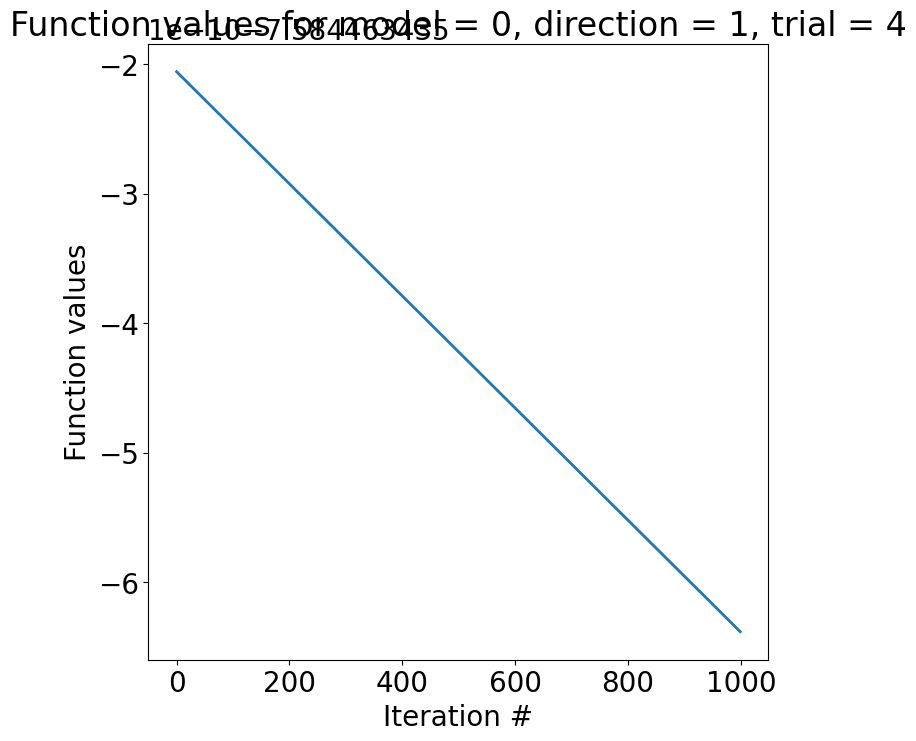

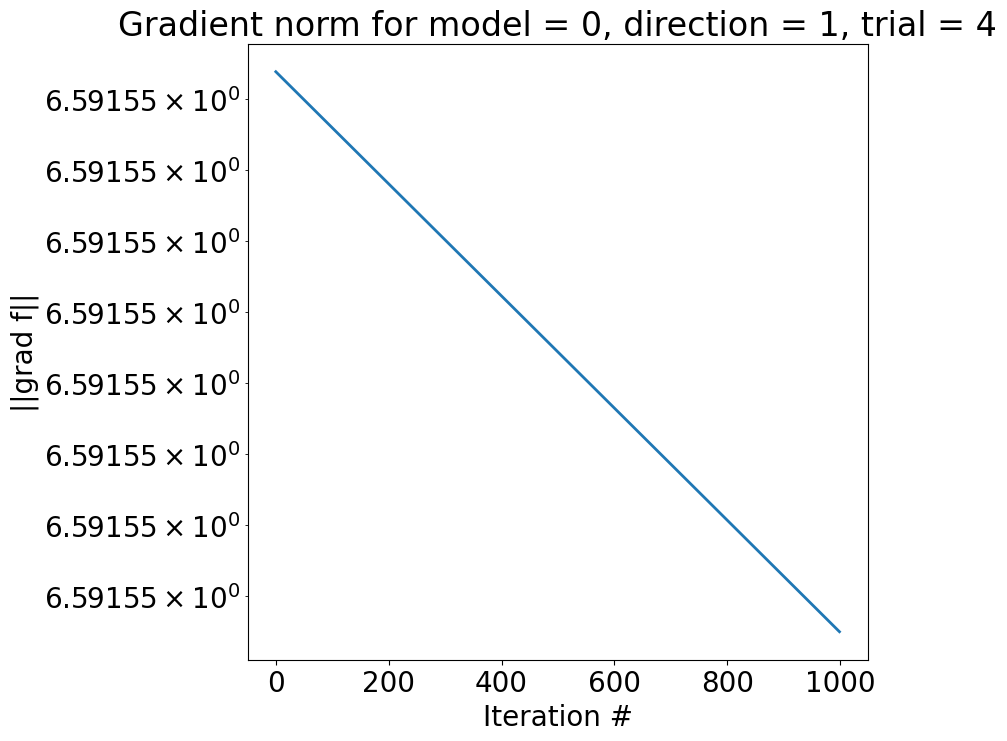

Initially, f =  -7.584463435205812 , ||grad f|| =  6.59155448084648
Result: f = -7.5844634357, ||grad f|| = 6.591554e+00


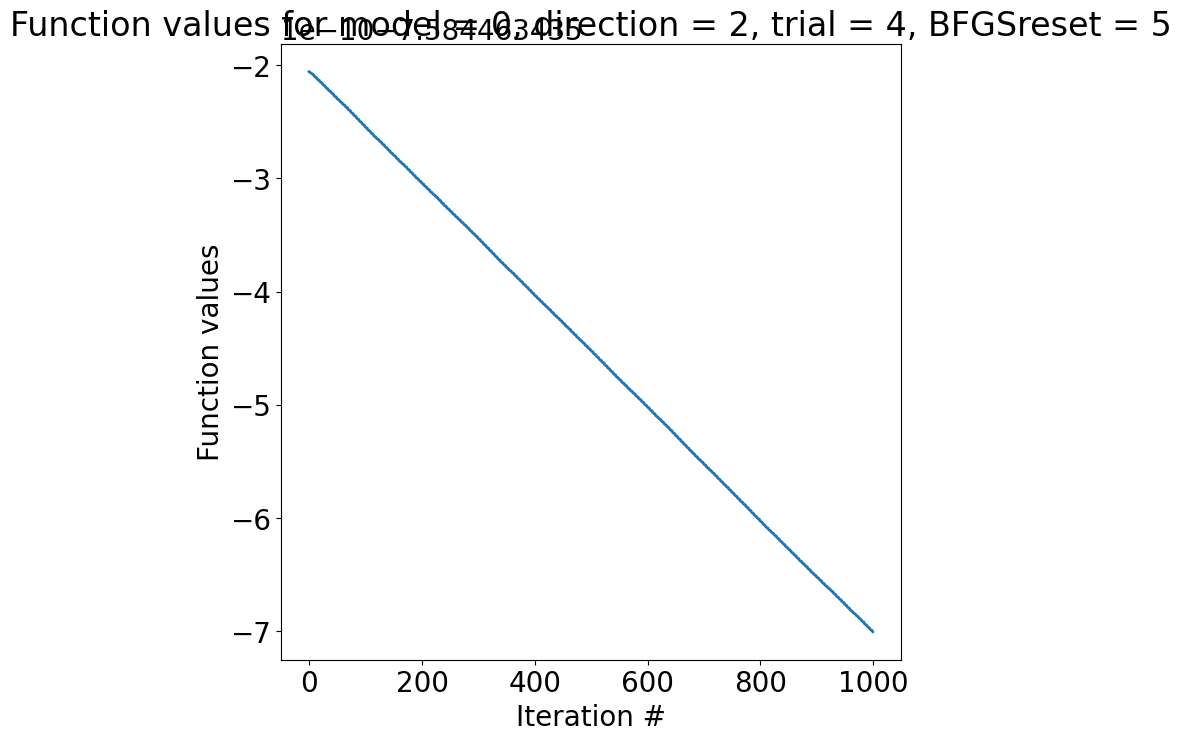

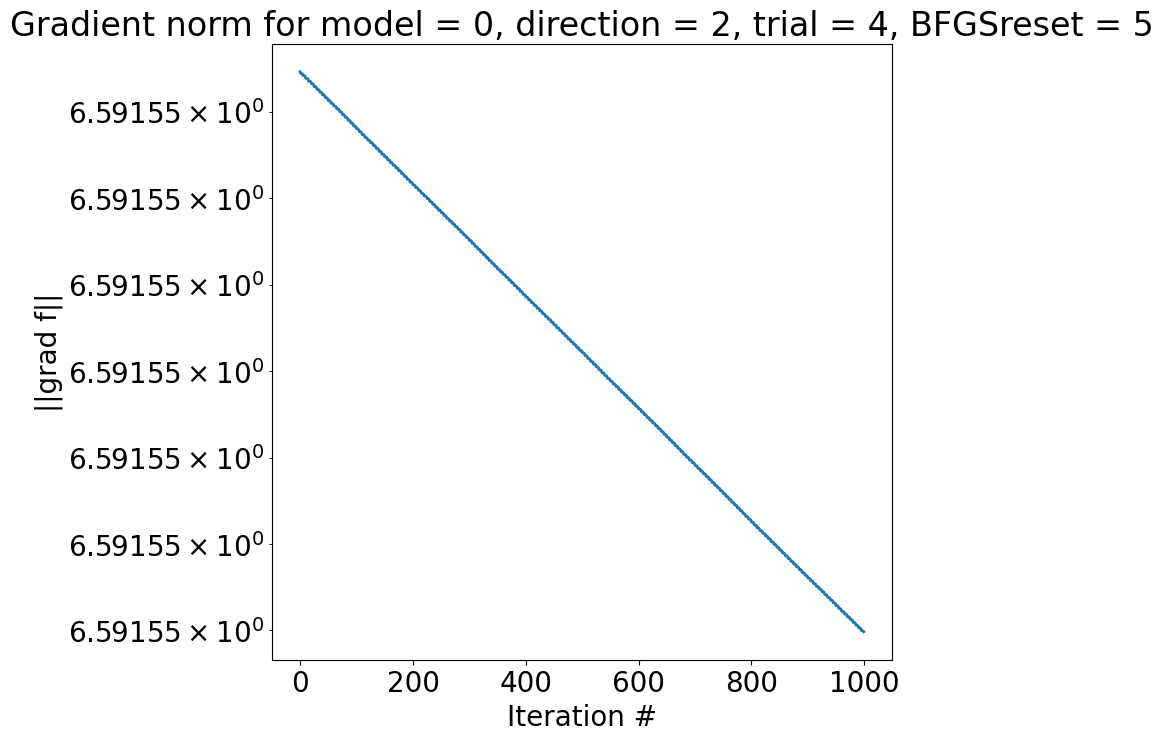

Initially, f =  -7.584463435205812 , ||grad f|| =  6.59155448084648
Result: f = -7.5844634369, ||grad f|| = 6.591554e+00


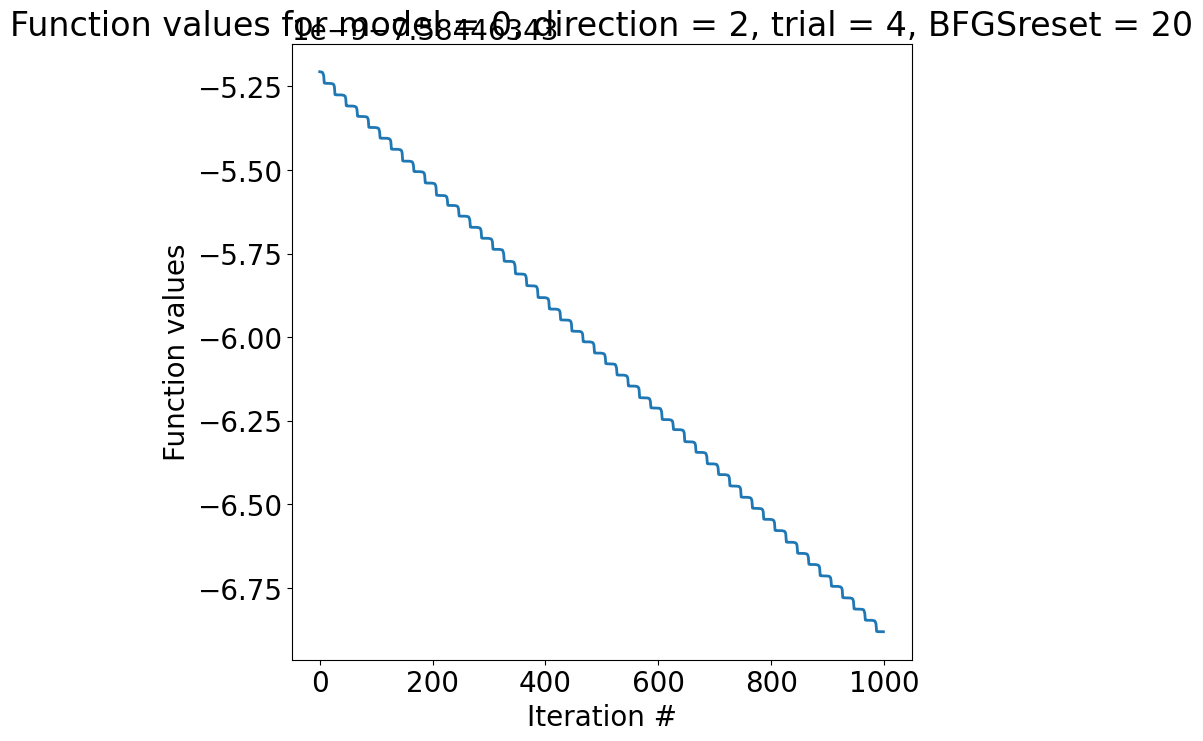

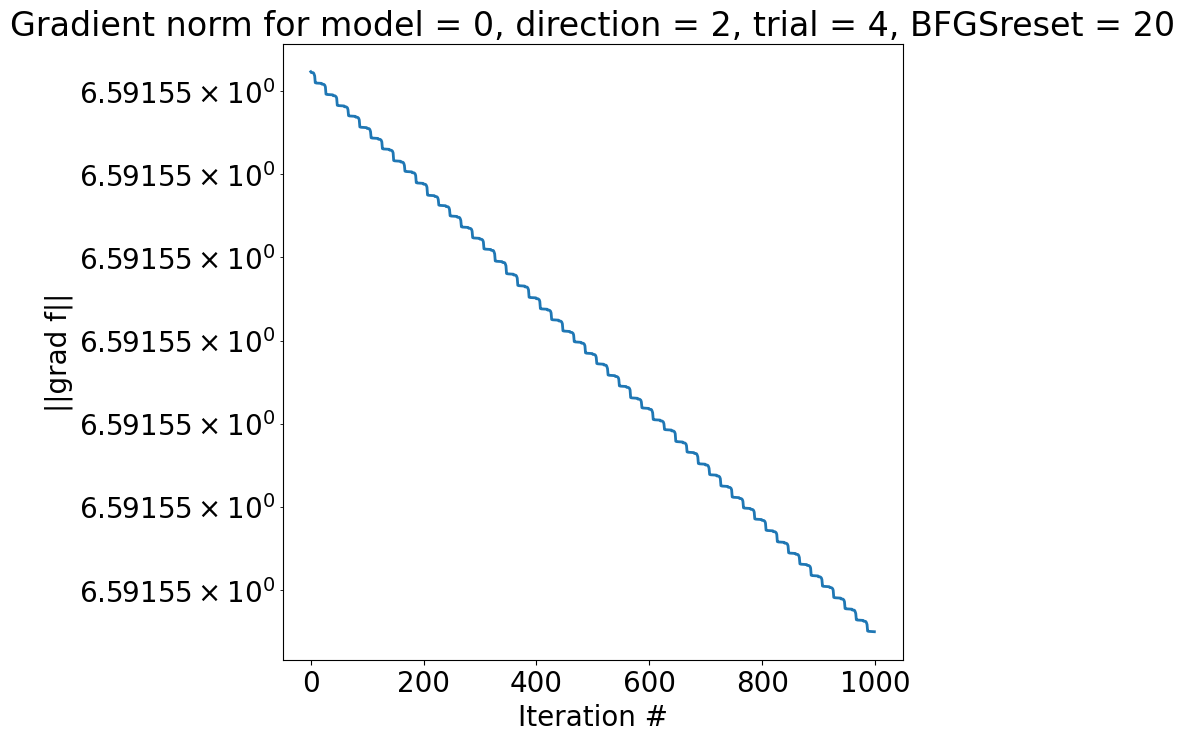

Initially, f =  126.82016194079515 , ||grad f|| =  2278.4907317070374
Result: f = 126.8201102910, ||grad f|| = 2.278490e+03


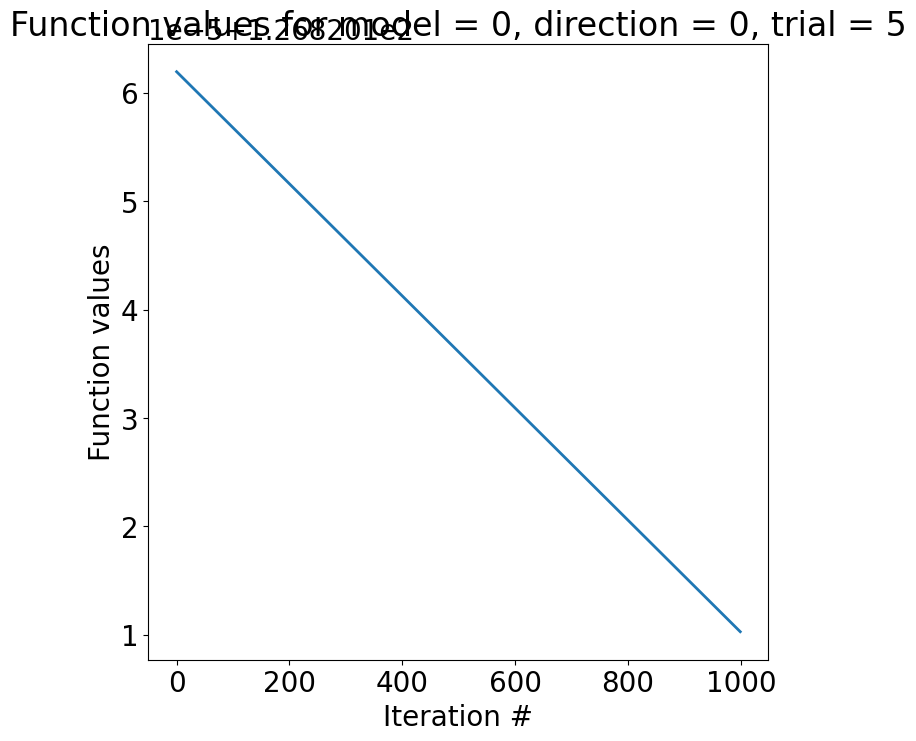

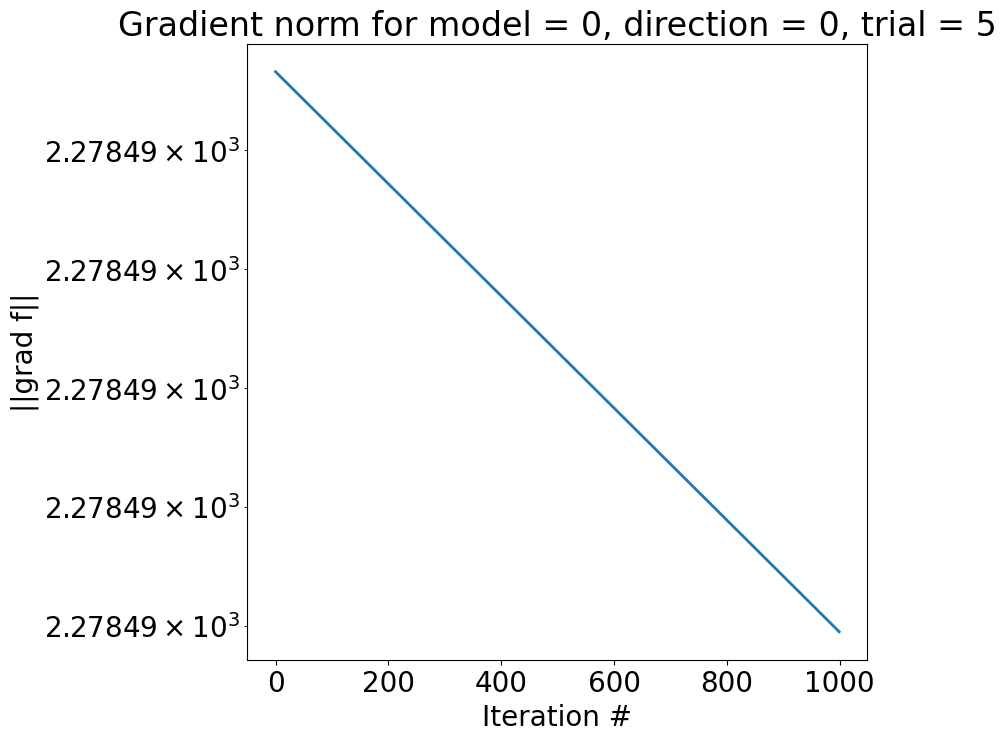

Initially, f =  126.82016194079515 , ||grad f|| =  2278.4907317070374
Result: f = 126.8201102910, ||grad f|| = 2.278490e+03


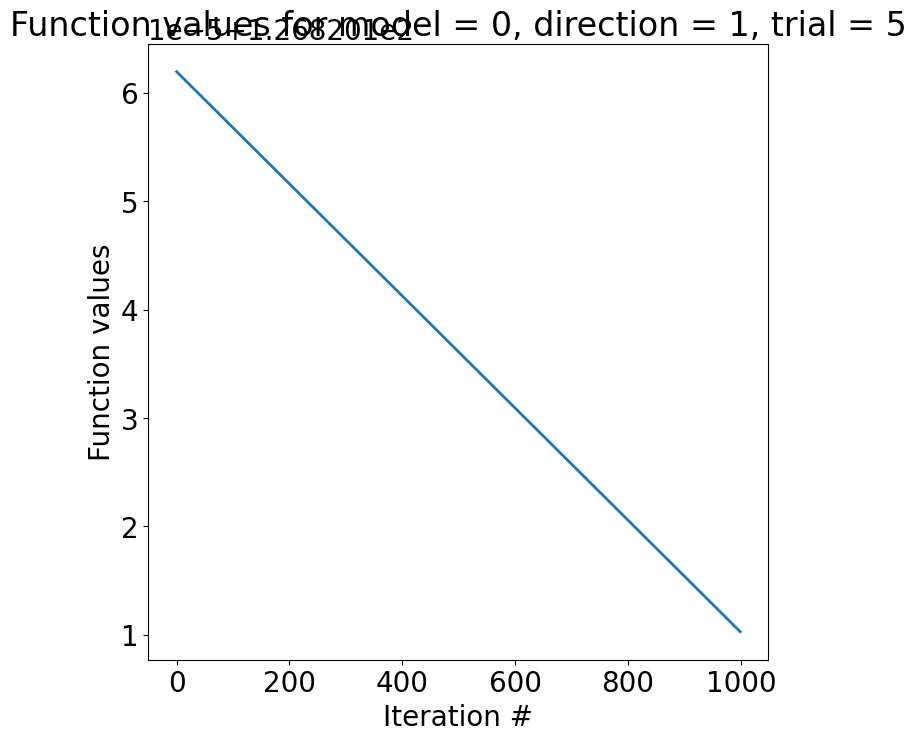

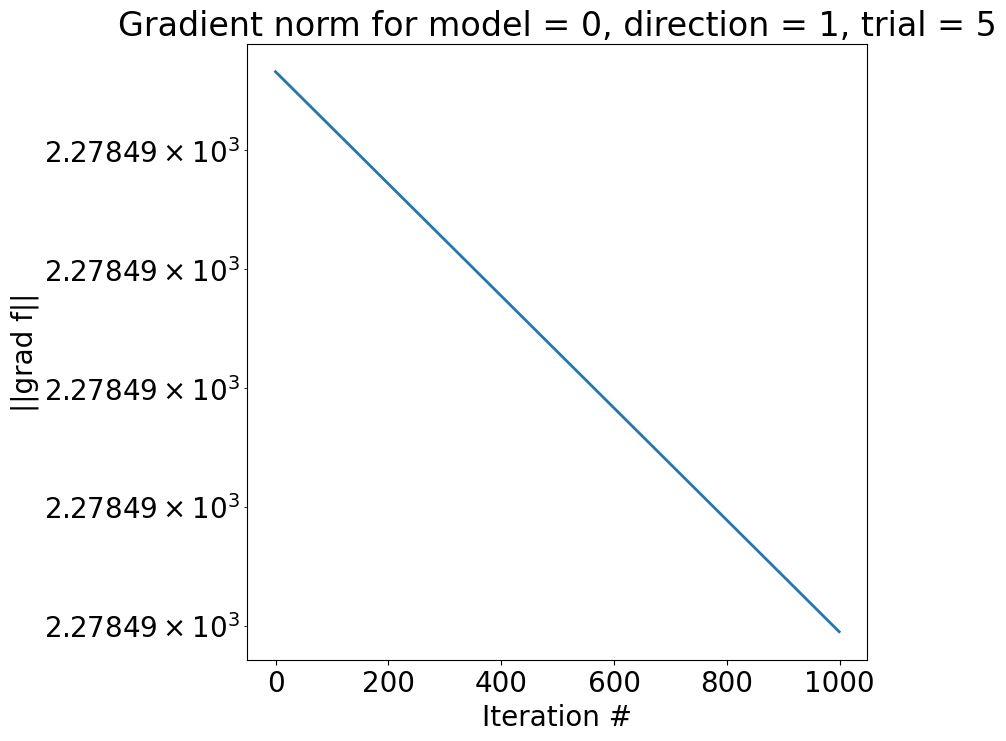

Initially, f =  126.82016194079515 , ||grad f|| =  2278.4907317070374
Result: f = 126.8201515627, ||grad f|| = 2.278491e+03


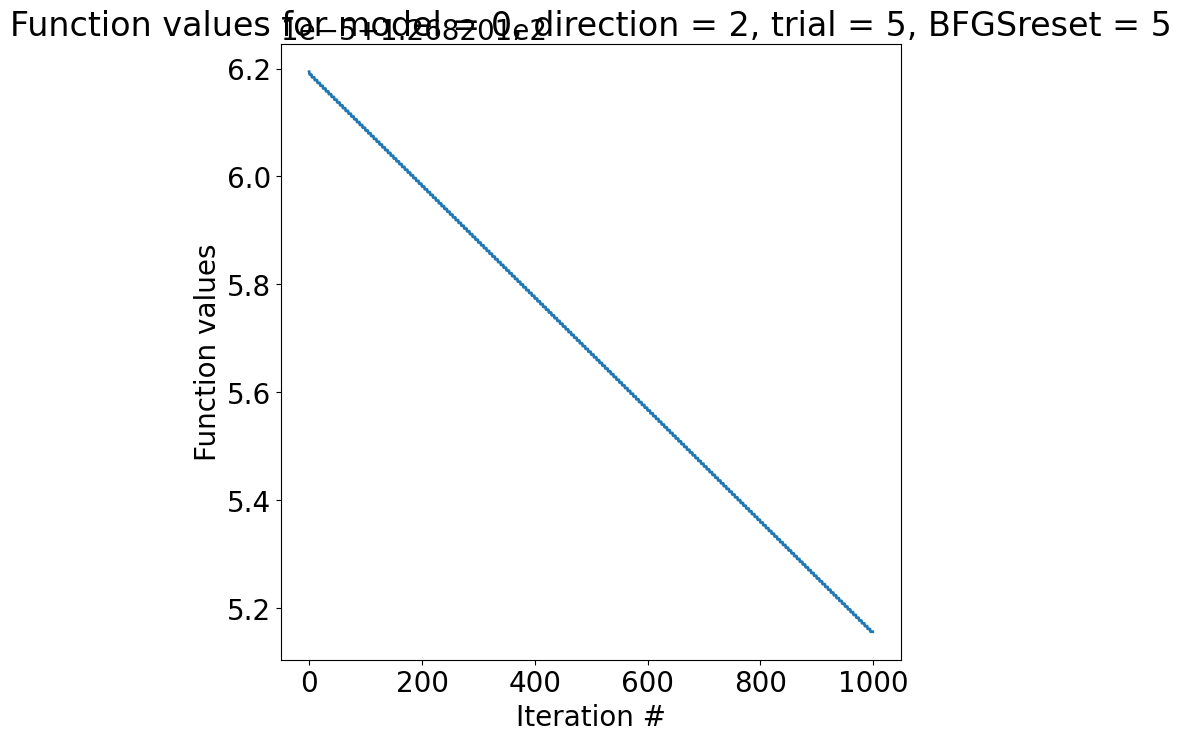

Initially, f =  126.82016194079515 , ||grad f|| =  2278.4907317070374
Result: f = 126.8201511962, ||grad f|| = 2.278491e+03


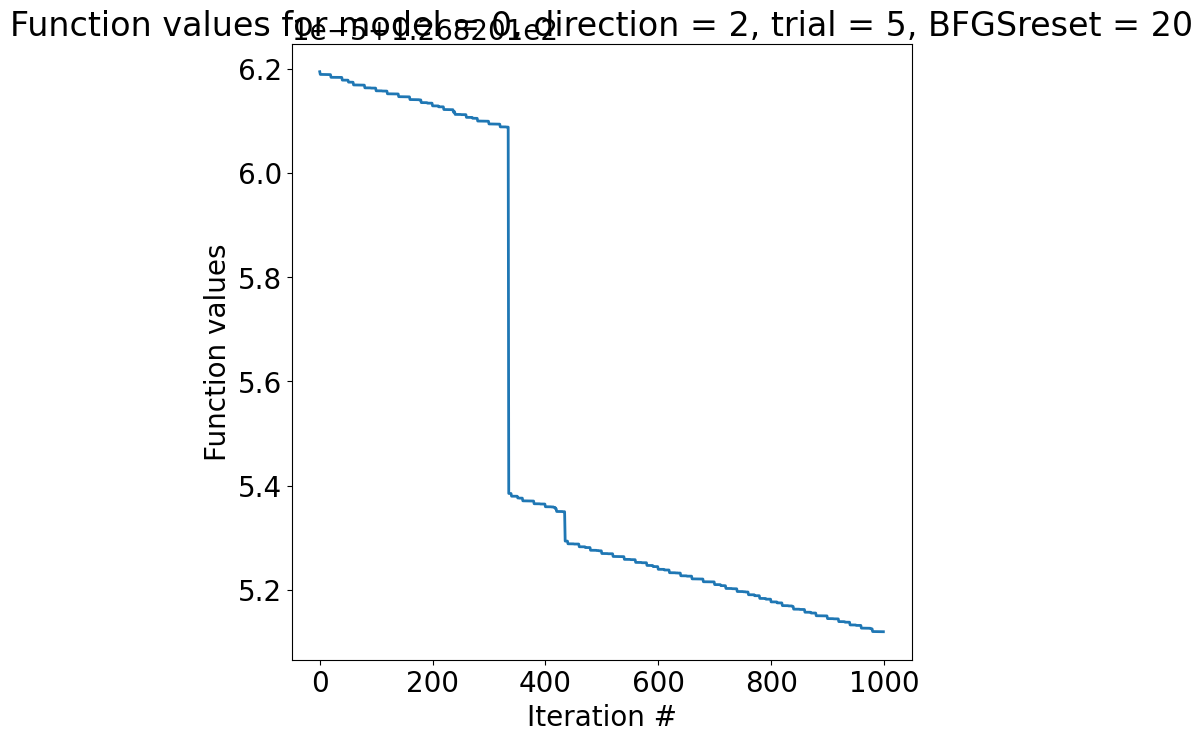

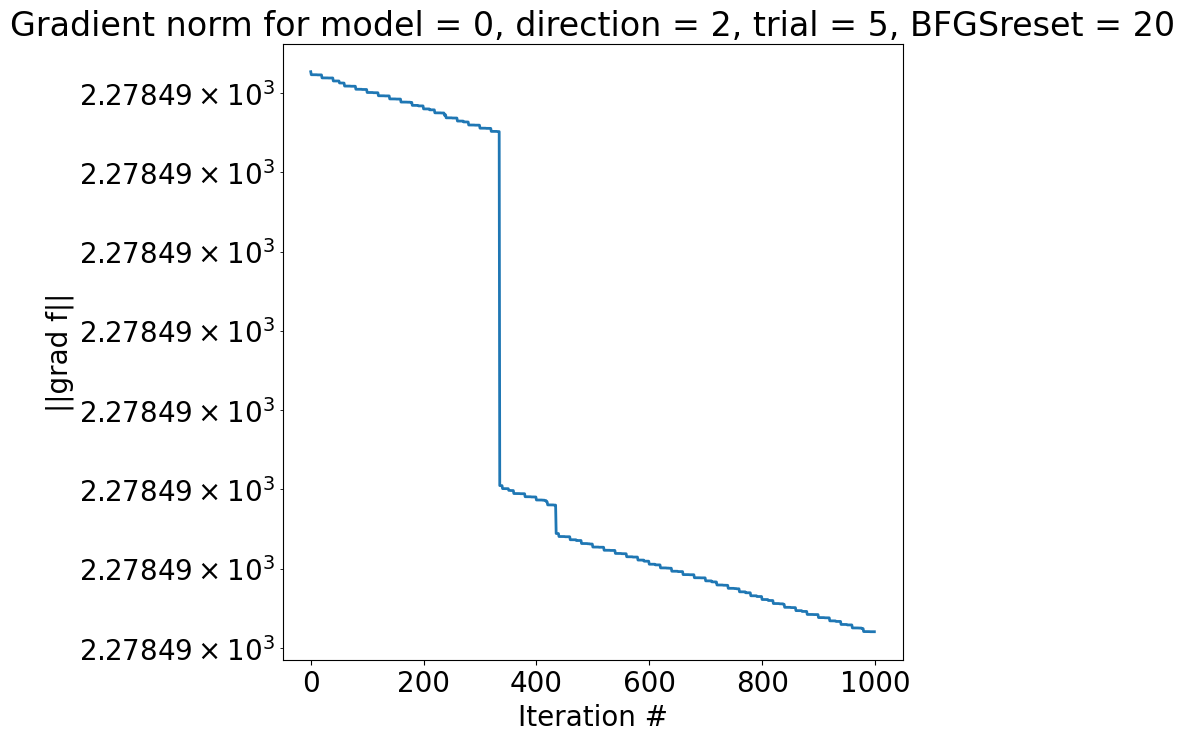

Initially, f =  -6.165903930158318 , ||grad f|| =  8.04786501267078
Result: f = -6.1659039308, ||grad f|| = 8.047865e+00


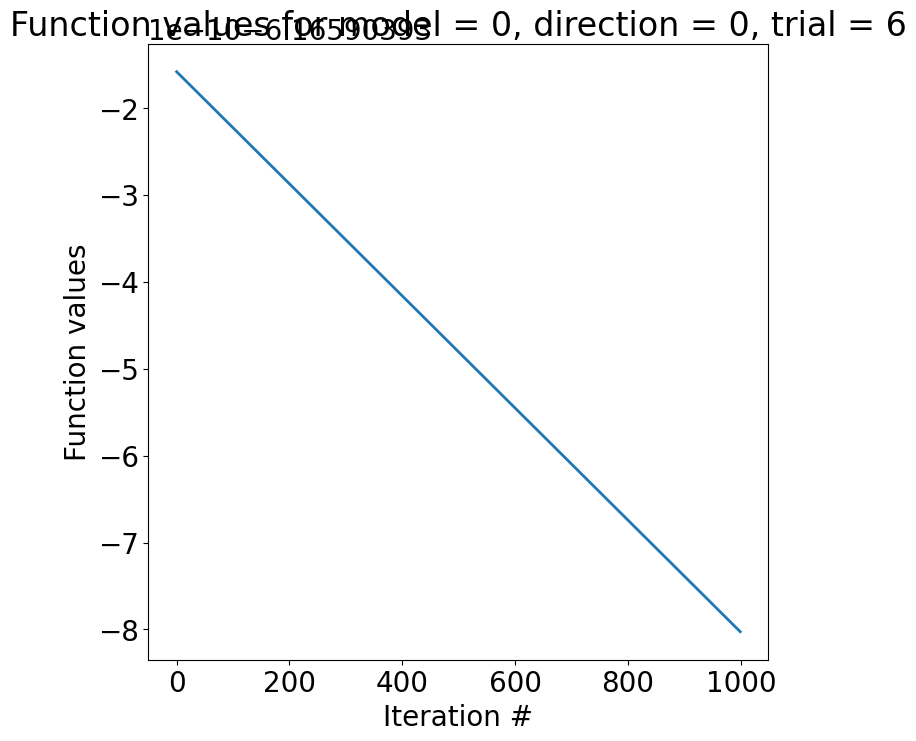

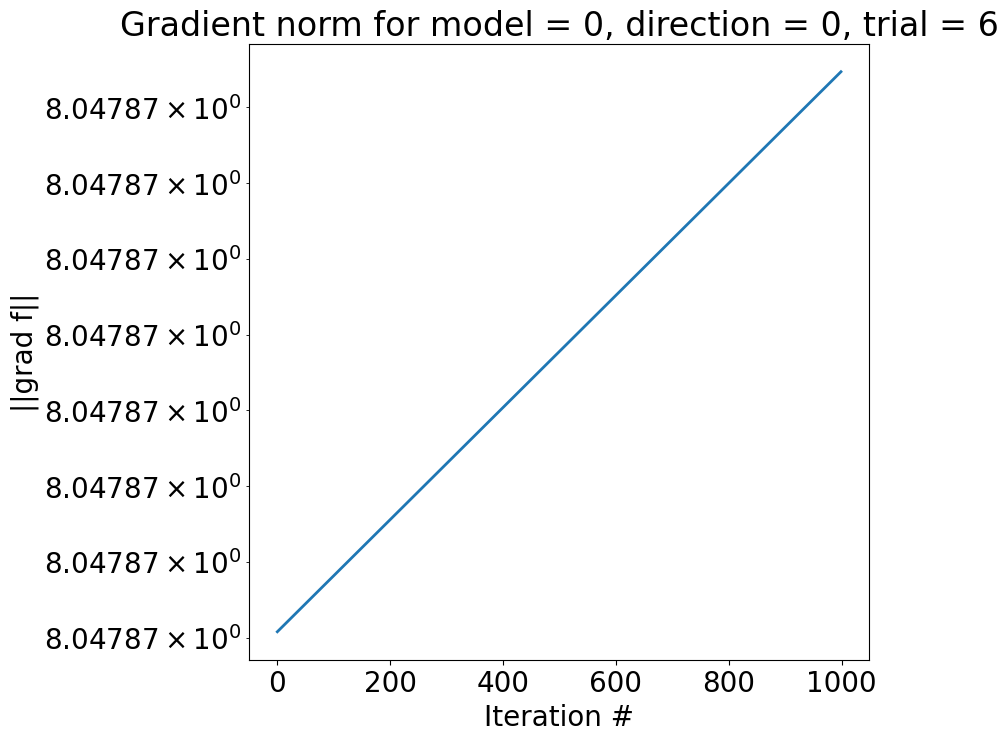

Initially, f =  -6.165903930158318 , ||grad f|| =  8.04786501267078
Result: f = -6.1659039308, ||grad f|| = 8.047865e+00


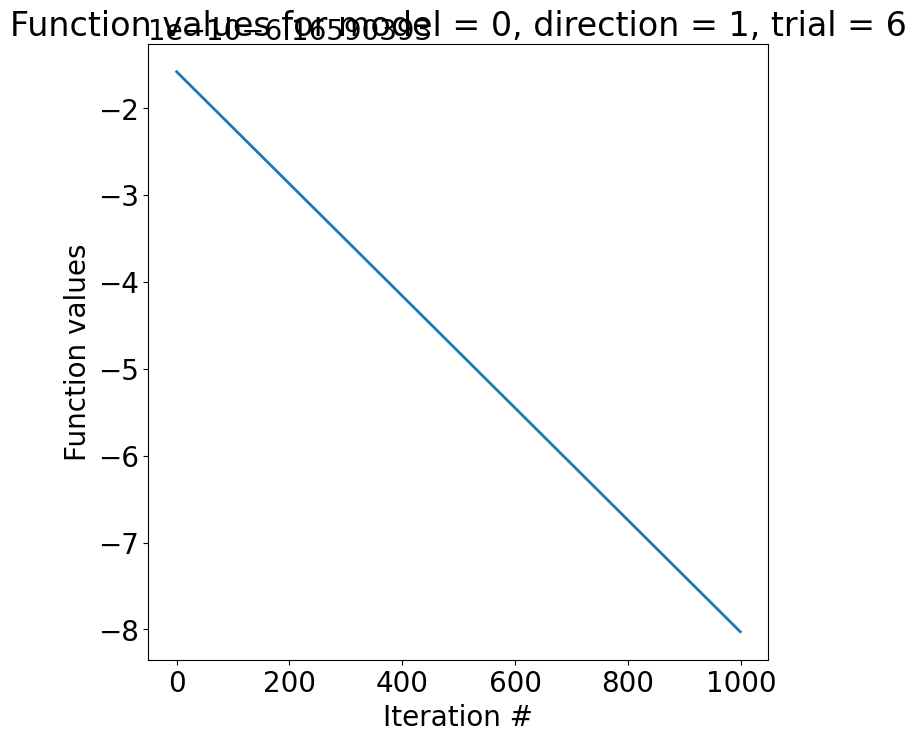

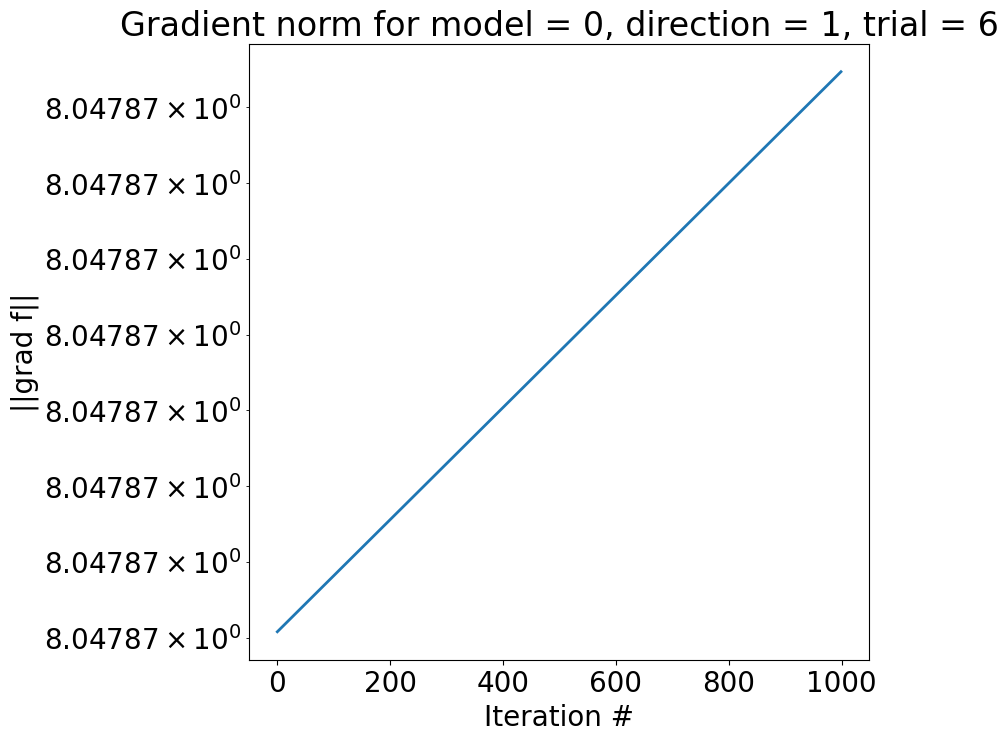

Initially, f =  -6.165903930158318 , ||grad f|| =  8.04786501267078
Result: f = -6.1659039307, ||grad f|| = 8.047865e+00


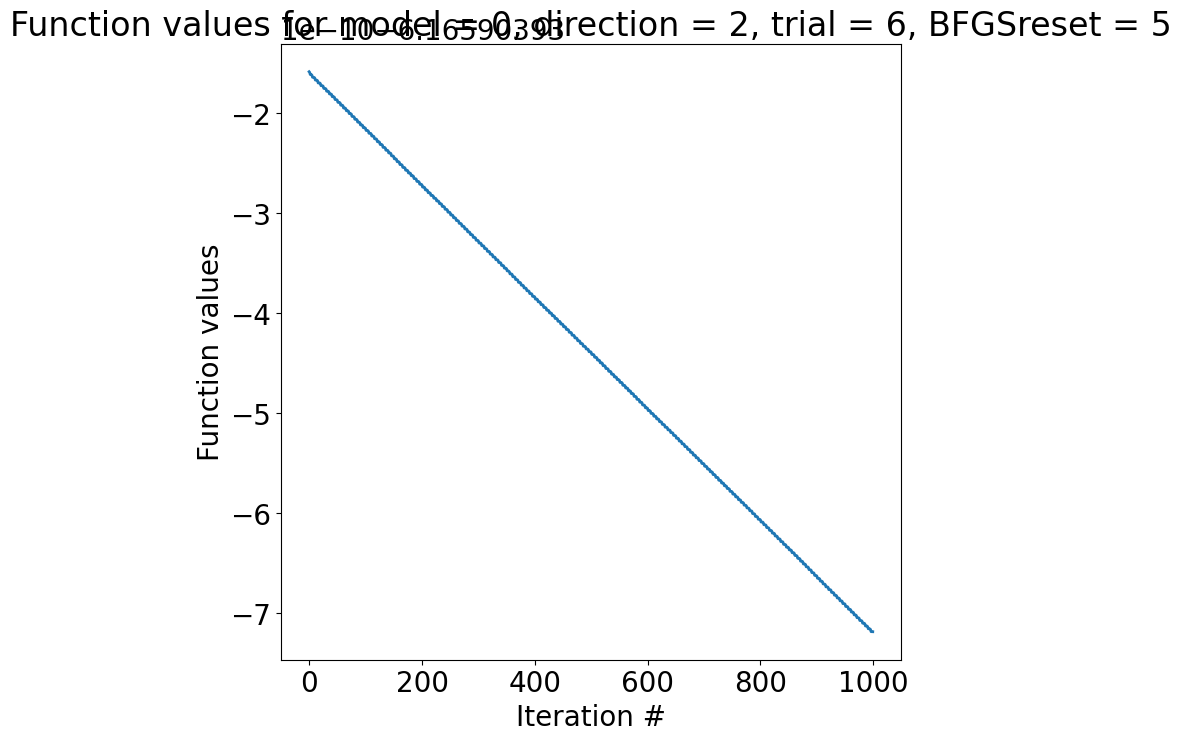

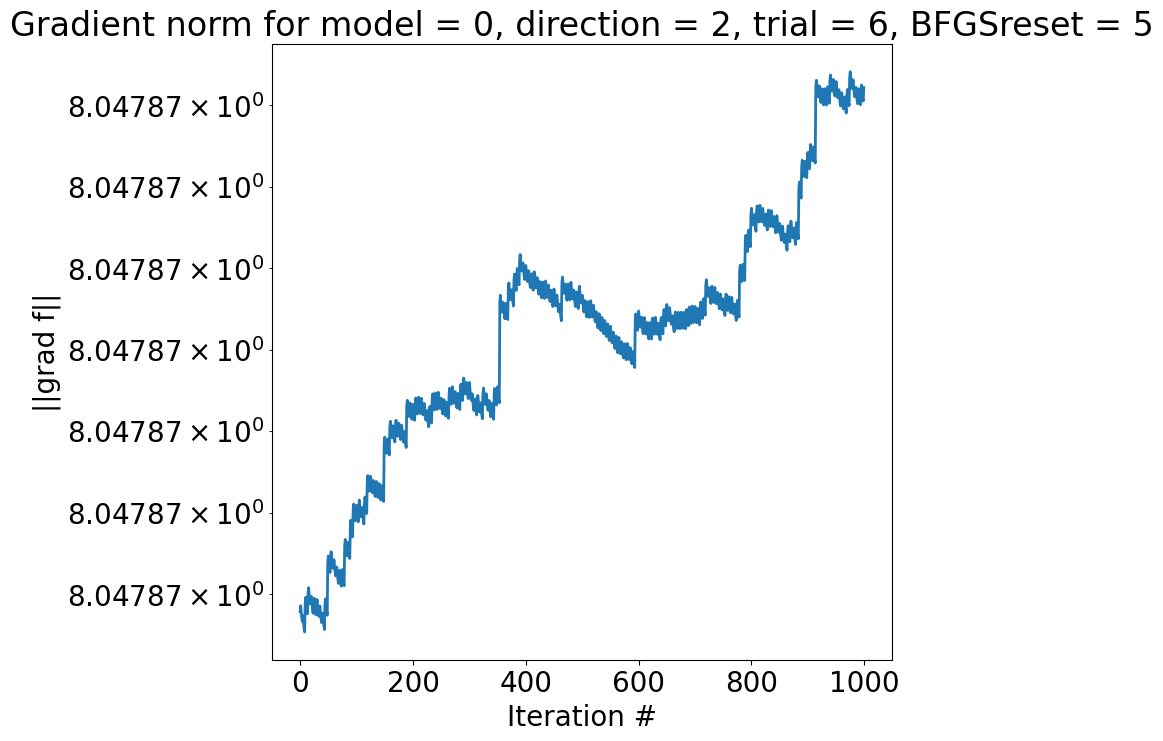

Initially, f =  -6.165903930158318 , ||grad f|| =  8.04786501267078
Result: f = nan, ||grad f|| = nan


C:\Users\RyanPC\AppData\Local\Temp\ipykernel_32216\1004308114.py:85: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = (y@y.T)/(y.T@s)
C:\Users\RyanPC\AppData\Local\Temp\ipykernel_32216\1004308114.py:85: RuntimeWarning: invalid value encountered in true_divide
  aux2 = (y@y.T)/(y.T@s)


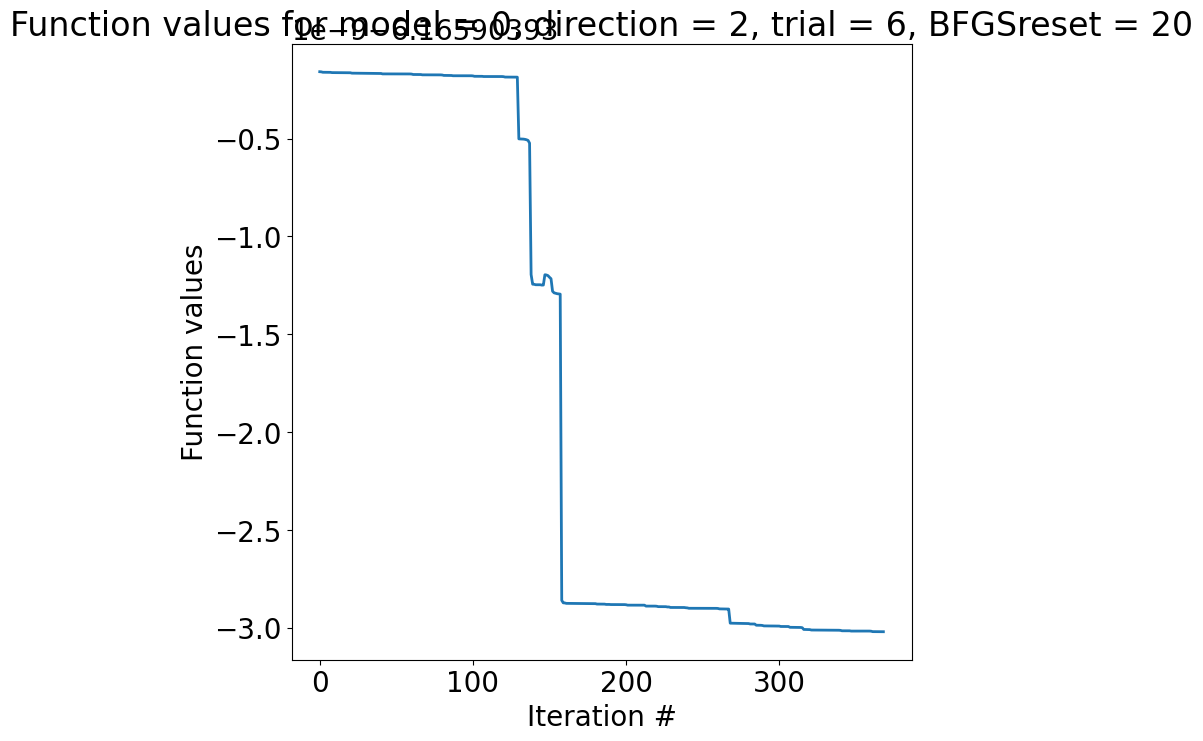

Initially, f =  -6.584354895303967 , ||grad f|| =  5.996986260189073
Result: f = -6.5843548957, ||grad f|| = 5.996986e+00


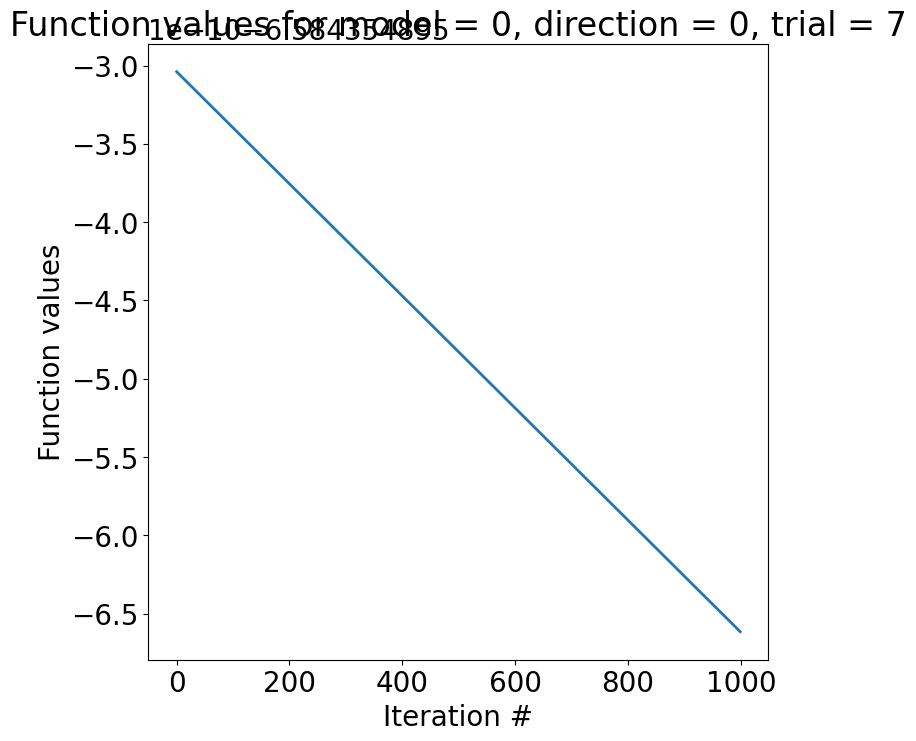

Initially, f =  -6.584354895303967 , ||grad f|| =  5.996986260189073
Result: f = -6.5843548957, ||grad f|| = 5.996986e+00


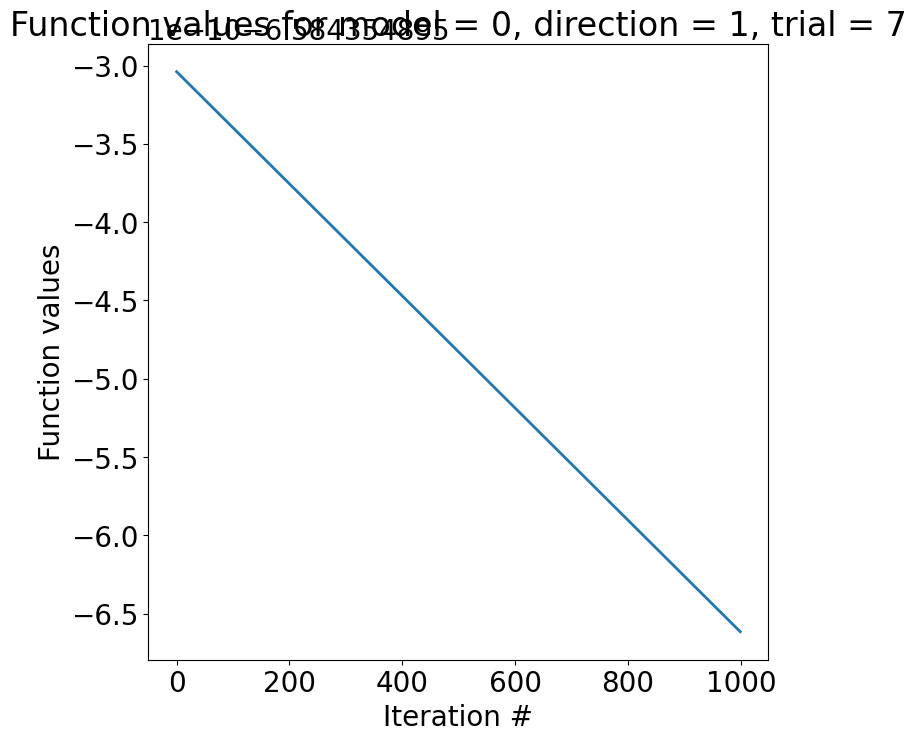

Initially, f =  -6.584354895303967 , ||grad f|| =  5.996986260189073
Result: f = -6.5843549002, ||grad f|| = 5.996986e+00


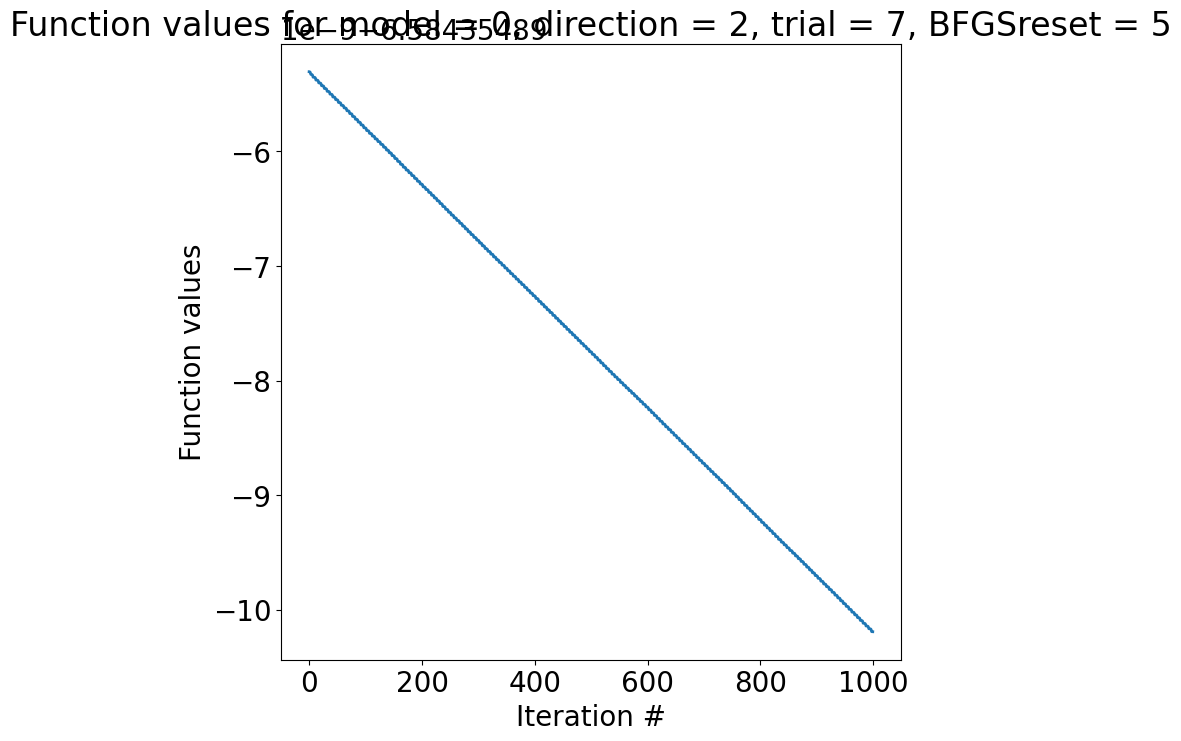

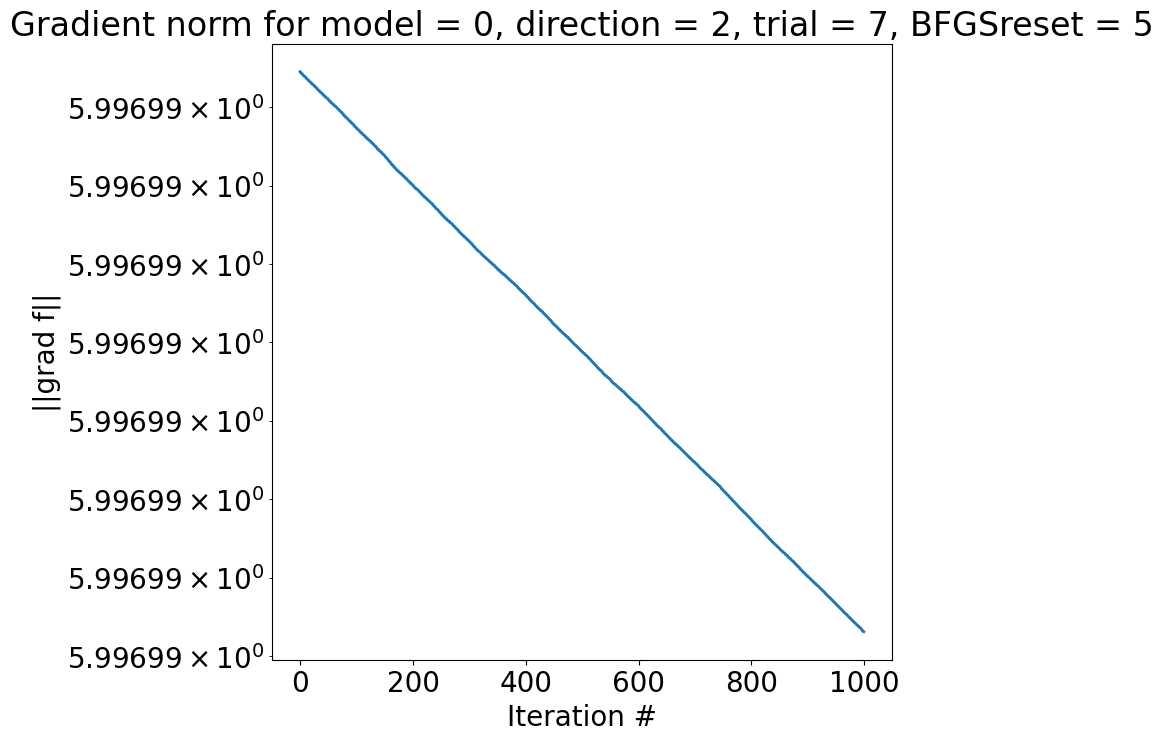

Initially, f =  -6.584354895303967 , ||grad f|| =  5.996986260189073
Result: f = nan, ||grad f|| = nan


Initially, f =  -6.9125821137368035 , ||grad f|| =  7.904901217130197
Result: f = -6.9125821144, ||grad f|| = 7.904901e+00


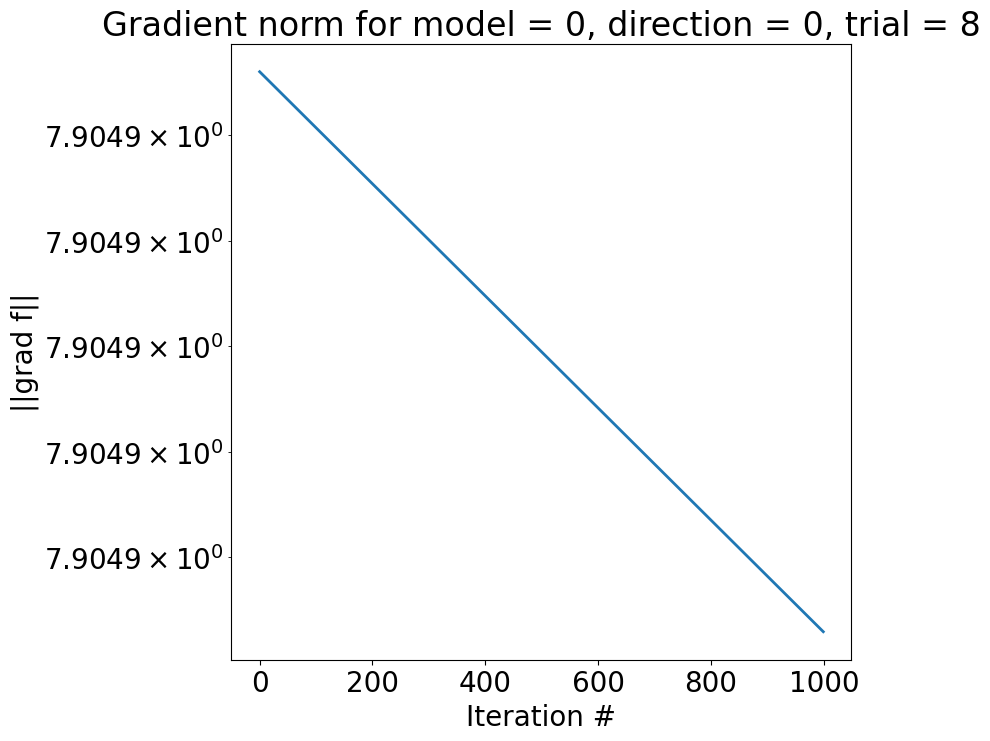

Initially, f =  -6.9125821137368035 , ||grad f|| =  7.904901217130197
Result: f = -6.9125821144, ||grad f|| = 7.904901e+00


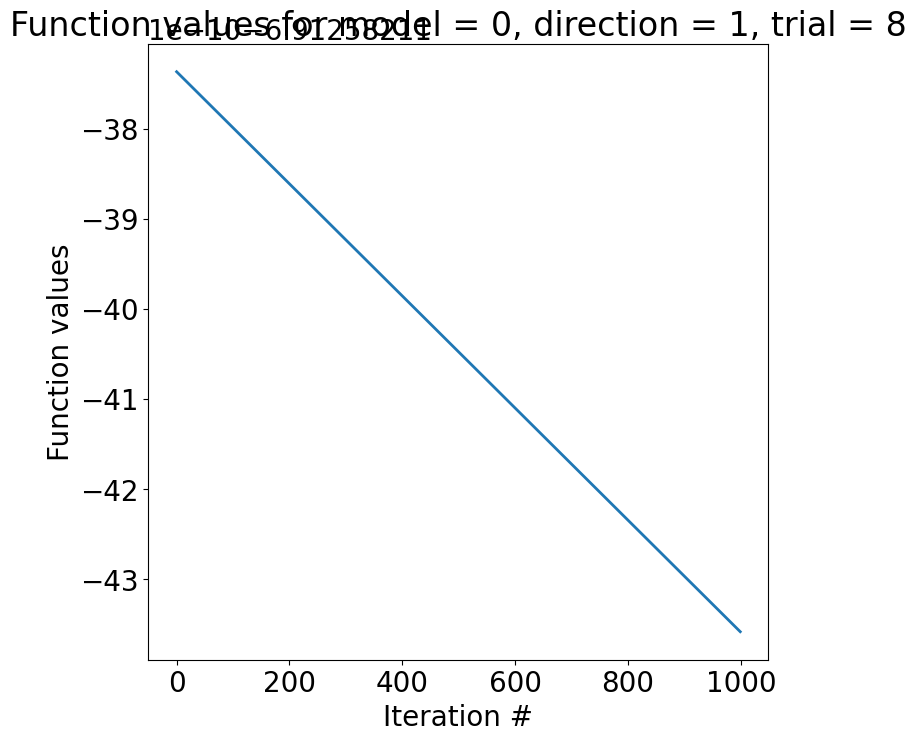

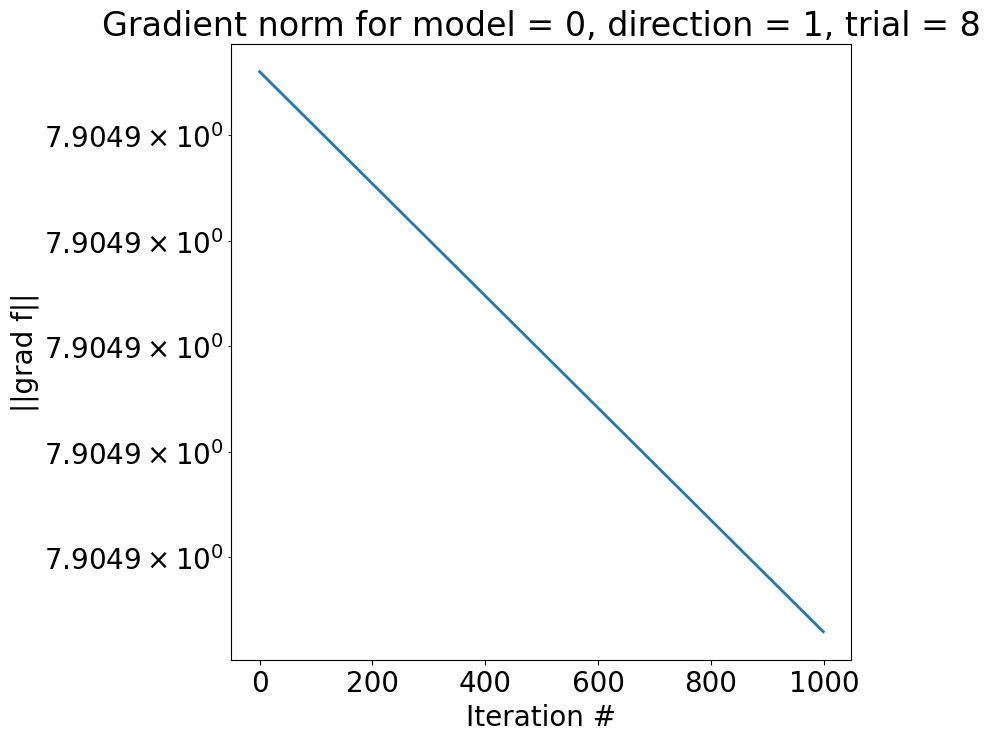

Initially, f =  -6.9125821137368035 , ||grad f|| =  7.904901217130197
Result: f = -6.9125821156, ||grad f|| = 7.904901e+00


Initially, f =  -6.9125821137368035 , ||grad f|| =  7.904901217130197
Result: f = -6.9125821206, ||grad f|| = 7.904901e+00


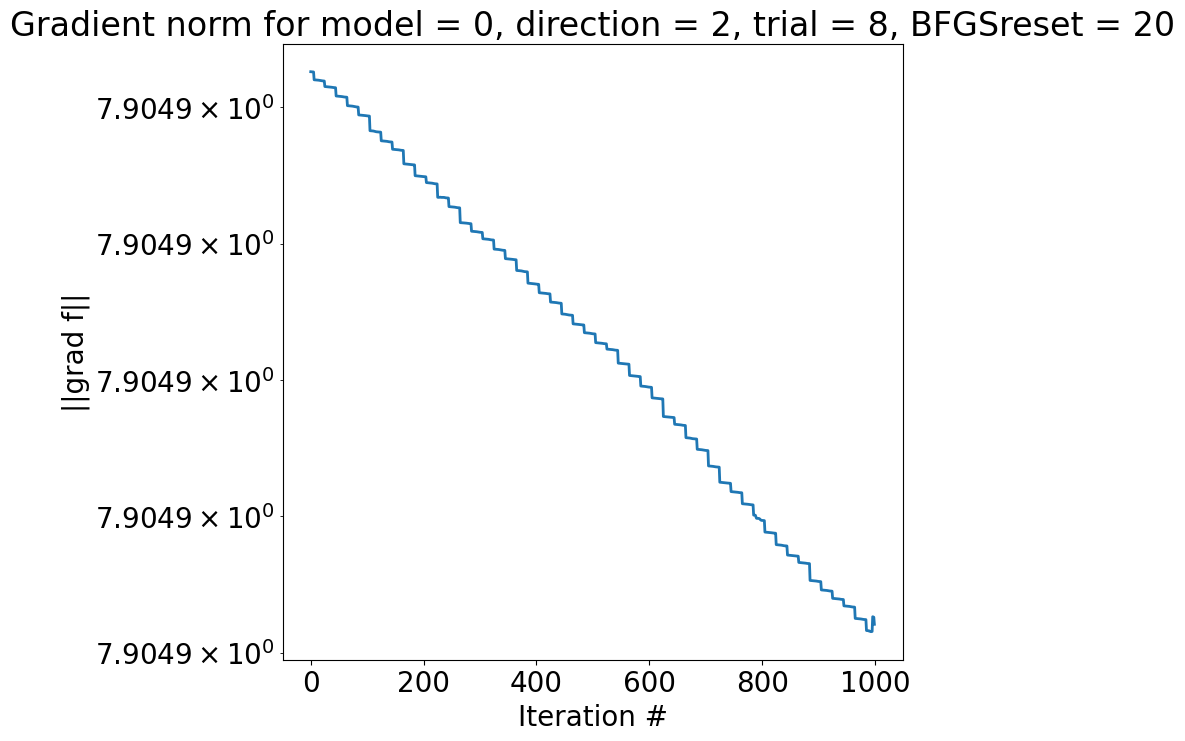

Initially, f =  111772.34512269197 , ||grad f|| =  3053499.0091665536
Result: f = 111679.6700464714, ||grad f|| = 3.050644e+06


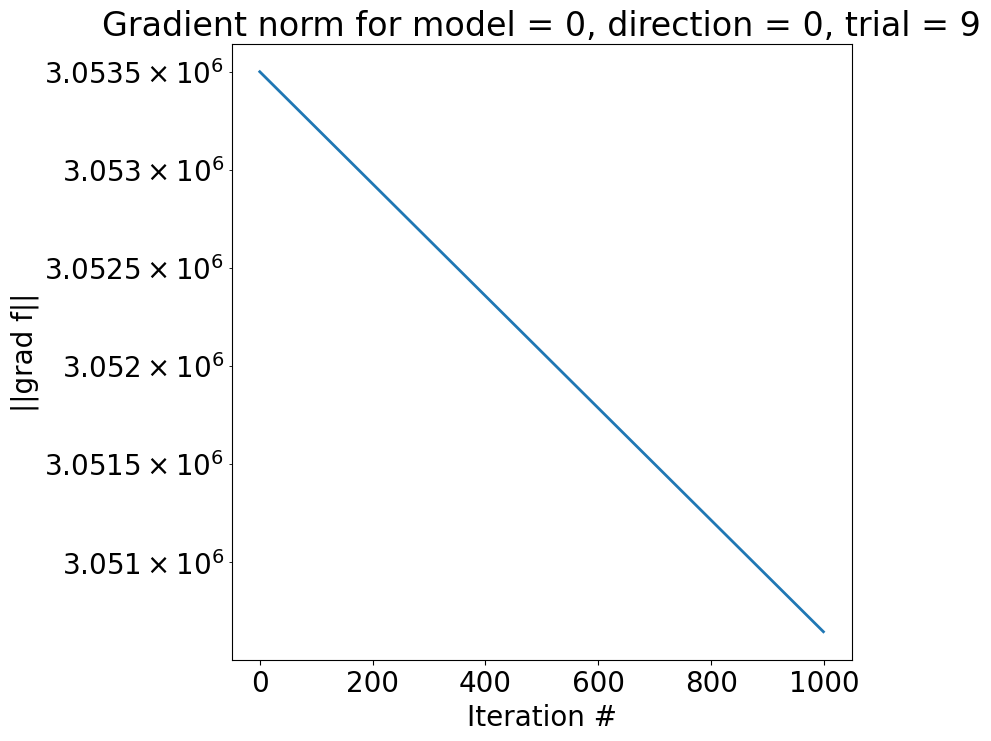

Initially, f =  111772.34512269197 , ||grad f|| =  3053499.0091665536
Result: f = 111679.6700464714, ||grad f|| = 3.050644e+06


Initially, f =  111772.34512269197 , ||grad f|| =  3053499.0091665536
Result: f = 111753.7623541919, ||grad f|| = 3.052927e+06


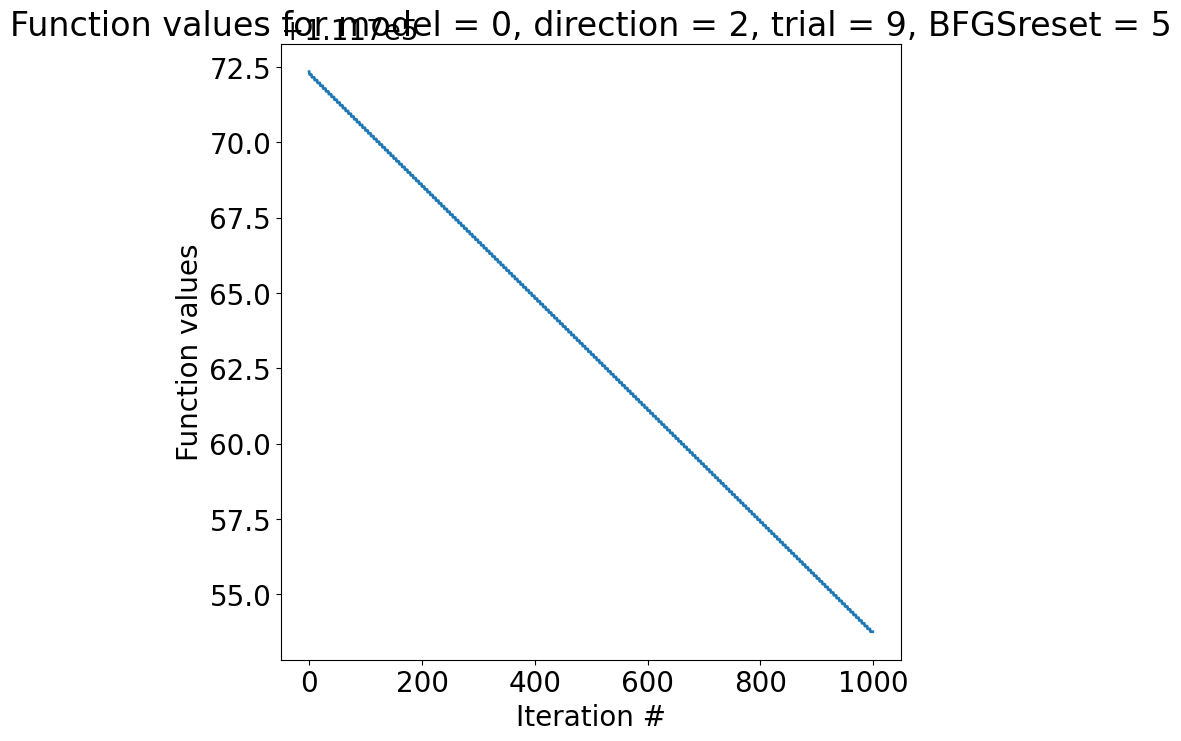

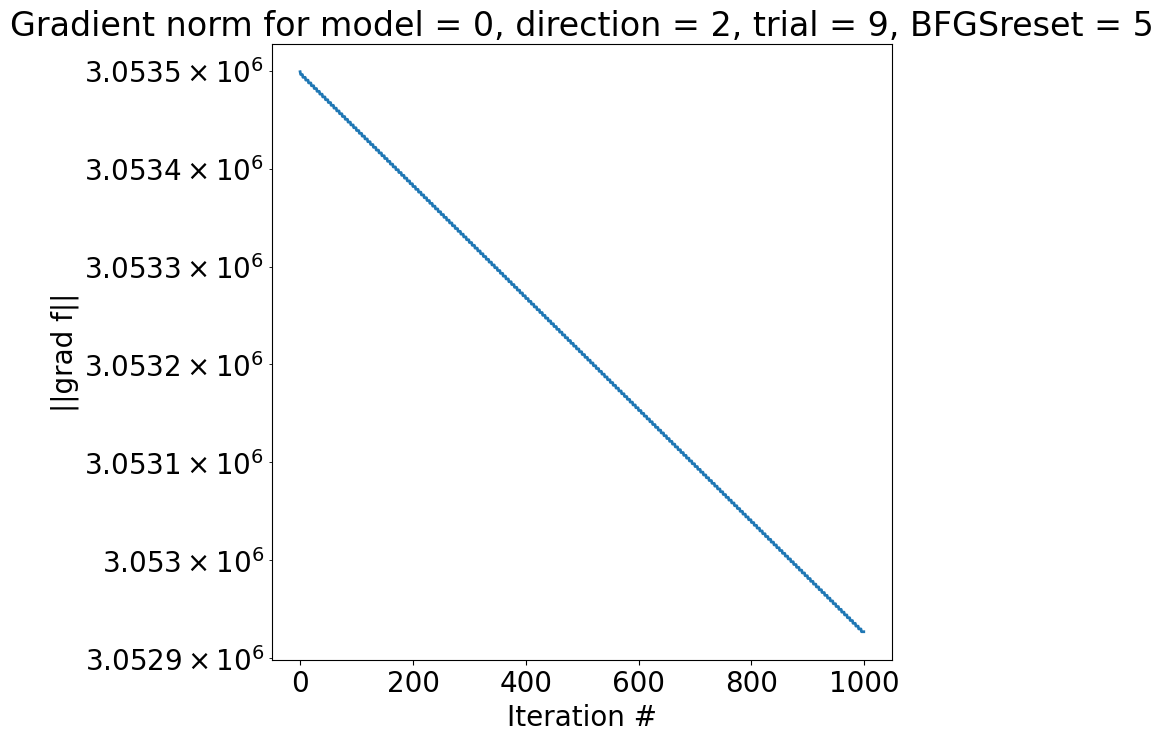

Initially, f =  111772.34512269197 , ||grad f|| =  3053499.0091665536
Result: f = 111767.6985203222, ||grad f|| = 3.053356e+06


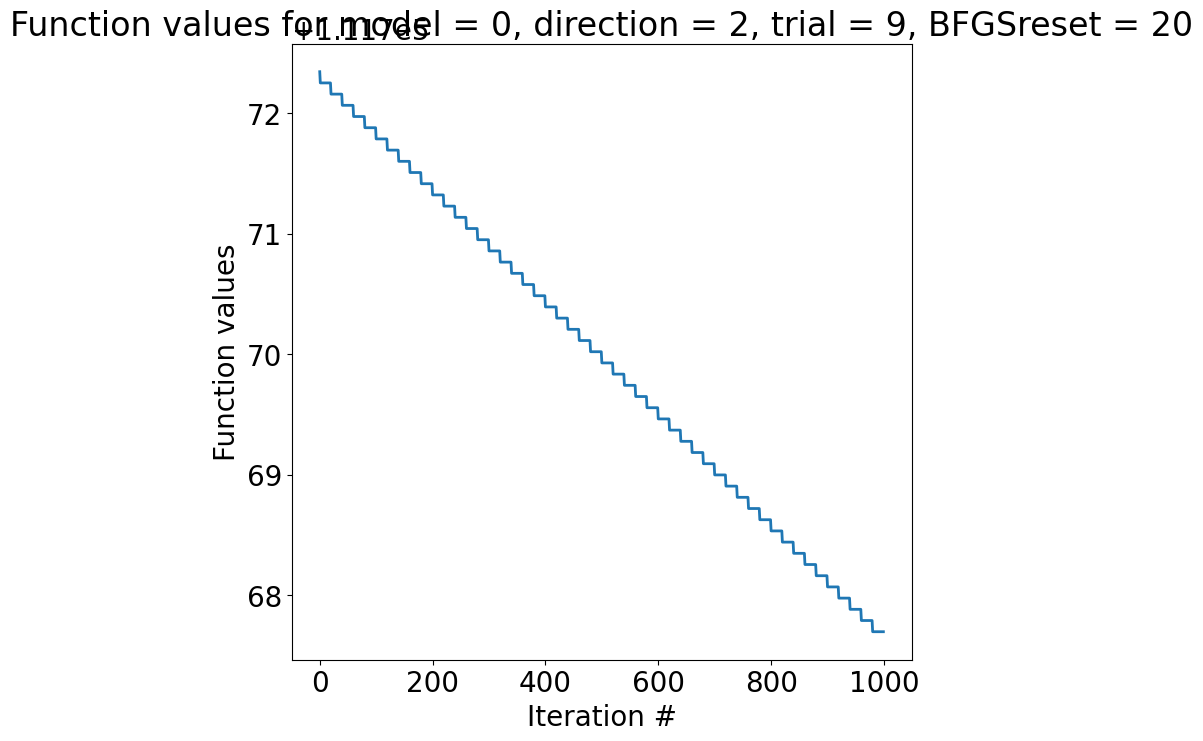

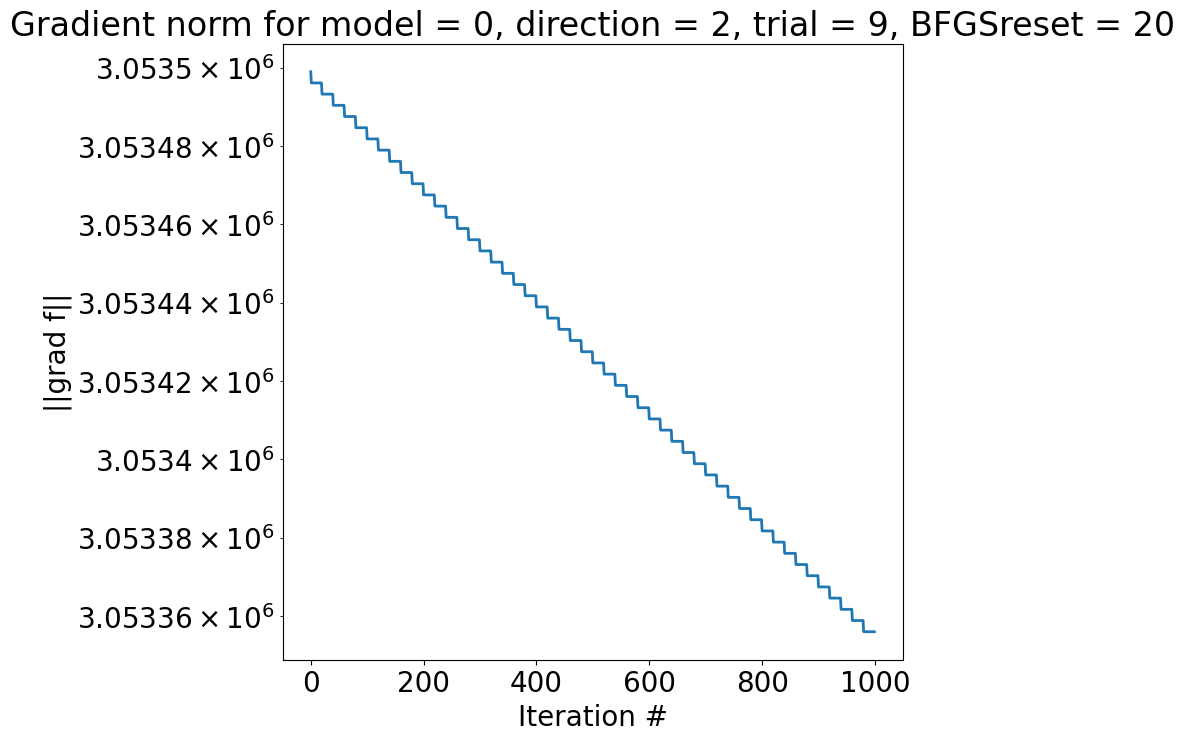

In [67]:
Na = 7

# four local minima of LJ7
for model in [1,2,3,4]:
    xyz = initial_configuration(model,Na,rstar)
    x = remove_rotations_translations(xyz)
    for direction in [0,1,2]:
        if direction == 2:
            for m in [5,20]:
                Minimization(x,model,direction,BFGSreset=m)
        else:
            Minimization(x,model,direction)

# ten random initial conditions
model = 0
for trial in range(10):
    xyz = initial_configuration(model,Na,rstar)
    x = remove_rotations_translations(xyz)
    for direction in [0,1,2]:
        if direction == 2:
            for m in [5,20]:
                Minimization(x,model,direction,randtrial=trial,BFGSreset=m)
        else:
            Minimization(x,model,direction,randtrial=trial)